<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Ames Housing Data and Kaggle Challenge


## Problem Statement

We are consultants hired by A real estate developer, researching on what factors impact the sale price most


how to allocate resources to improve participation rates and/or scores for SAT and/or ACT in the United States.
In this project, we intend to evaluate if there is a ACT score bias for households with higher or lower median income. Specifically, we will explore the association of statewide ACT mean score and median family income, and try to establish a linear regression model between them


### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [export data](#Exporting-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hypothesis Test](#Hypothesis-Test)
- [Linear regression model](#Linear-regression-model)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Data Visualization](#Visualize-the-Data)
- [get best classifier](#get-best-classifier)
- [Kaggle](#Kaggle) 

## Background

# Import libraries

In [315]:
# Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoCV, RidgeCV,Ridge,Lasso
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler,PolynomialFeatures


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer



import copy

get_ipython().run_line_magic('matplotlib', 'inline')


pd.options.display.max_columns = None
pd.options.display.max_rows = None



corr_threhold = 0.4  # threhold for feature selection
is_y_logged=True



# define some functions

In [316]:
def plot_features_numeric(df,x_columns, y_column):
    fig, axs = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for i in range(len(x_columns)):
        sns.histplot(data=df, x=x_columns[i], kde=True, color="skyblue", ax=axs[i])
    sns.pairplot(df, x_vars=x_columns, y_vars=y_column)

In [317]:
def plot_features_catagorical(df,x_columns, y_column):
    fig, axs = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for i in range(len(x_columns)):
        sns.histplot(data=df, x=x_columns[i], kde=False, color="skyblue", ax=axs[i])
    
    fig2, axs2 = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for j in range(len(x_columns)):
         sns.boxplot(x=x_columns[j], y=y_column, data=df, ax=axs2[j])
    

In [318]:
def get_indexs_of_outliers_IQR(df, features, cut_off_IQR, direction="upper"):
    
    result_set = set()
    
    for feature in features:
        print("feature name:", feature)
        # calculate interquartile range
        q25, q75 = df[feature].quantile(0.25), df[feature].quantile(0.75)
        iqr = q75 - q25
        print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

        if iqr > 0:
            # calculate the outlier cutoff
            cut_off = iqr * cut_off_IQR
            lower, upper = q25 - cut_off, q75 + cut_off
            if direction == 'both':
                result_set.union(set(df[(df[feature]<= lower) | (df[feature]>=upper)].index))
            elif direction == 'lower':
                result_set.union(set(df[df[feature]<= lower].index))
            elif direction == 'upper':
                temp_result = set(df[(df[feature]>=upper)].index)
                print(temp_result)
                result_set.update(temp_result)
            else:
                print("wrong direction")
                return []
    print("done")
    return list(result_set)
 
        

In [319]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [320]:
def model_performance(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    print('mse', mse_test)
    

In [321]:
def get_best_gridSearchCV(X,y):   
    # define the pipeline
    #scaler = StandardScaler()
    #scaler = MinMaxScaler()
    scaler = RobustScaler()

    # Initialze the estimators
    model1 = LinearRegression()
    model2 = Ridge()
    model3 = Lasso()

    threhold_perc_diff = 2
    best_mse_test = None
    best_perc_diff = None
    #alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
    alphas = np.logspace(0, 5, 100)
    best_alpha= None
    best_gs = None


    # Initialize the hyperparameters for each dictionary
    param1 = {}
    param1['classifier'] = [model1]
    param2 = {}
    param2['classifier__alpha'] = alphas
    param2['classifier'] = [model2]
    param3 = {}
    param3['classifier__alpha'] = alphas
    param3['classifier'] = [model3]

    # create pipeline
    pipeline = Pipeline(steps=[('scaler', scaler), ('classifier', model1)])
    #pipeline = Pipeline(steps=[('classifier', model1)])
    params = [param1, param2, param3]


    # Train the grid search model
    # run GridsearchCV
    gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    stop_count = 0
    success_random_keys=dict()

    for random_key in range(10000): 

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_key)

            gs.fit(X_train, y_train)

            # Best performing model and its corresponding hyperparameters
            print('best performing model:', gs.best_params_)

            # MSE score for the best model
            # need to convert to positive
            # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
            print('Mse score: ', abs(gs.best_score_))

            # check for generalisation

            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)

            if is_y_logged:
                mse_train = mean_squared_error(np.exp(y_train), np.exp(y_train_pred))
                mse_test = mean_squared_error(np.exp(y_test), np.exp(y_test_pred))
            else:
                mse_train = mean_squared_error(y_train, y_train_pred)
                mse_test = mean_squared_error(y_test, y_test_pred)
            perc_diff = (mse_train - mse_test)/mse_train * 100
            print('mse of train data: ', mse_train)
            print('mse of test data: ', mse_test)
            print('diff%: ', str(perc_diff)+"%")

            if (np.abs(perc_diff) < threhold_perc_diff):
                print("random key: ",random_key)
                success_random_keys[random_key]= mse_test     
                if len(success_random_keys)>0:
                    break

    print(success_random_keys)
    return gs

 

In [322]:
def target_encoding_fit(df, feature_to_be_encoded,target_variable): 
#result=(df.loc[df['source']=='train',:].groupby("Neighborhood").median()[target_variable]).to_dict()
    result=(df.groupby(feature_to_be_encoded).median()[target_variable]).to_dict()
    print(result)
    return result

In [323]:
from collections import defaultdict

def target_encoding_nonnumeric_features(df_full, df_train, features_to_be_encoded,target_variable):
    
    result_dict = dict()
    
    for feature in features_to_be_encoded:
        one_feature_full_dict=(df_full.groupby(feature).median()[target_variable]).to_dict()
        one_feature_train_dict = (df_train.groupby(feature).median()[target_variable]).to_dict()
        one_feature_result_dict = defaultdict(lambda:0)
        
        for key, value in one_feature_full_dict.items():
            if value == np.nan:
                print(key, 'is null')
            if key in one_feature_train_dict:
                if one_feature_train_dict[key] == np.nan:
                    one_feature_result_dict[key] = 0
                else:
                    one_feature_result_dict[key]= one_feature_train_dict[key]
            else:
                one_feature_result_dict[key]=0

        result_dict[feature]=one_feature_result_dict
        
    print(result_dict)
    return result_dict

## Data Import and Cleaning
- to avoid repeating work, we will concatenate datasets from 'train.csv' and 'test.cvs'
- we will 

In [324]:
# read the files
df_train = pd.read_csv("../datasets/train.csv")
df_train['source'] = 'train'
print("shape of 'train.csv'", df_train.shape)

df_test = pd.read_csv("../datasets/test.csv")
df_test['source'] = 'test'
print("shape of 'test.csv'", df_test.shape)

df = pd.concat([df_train,df_test], ignore_index = True, sort = False)

print("shape of 'df'", df.shape)
df.head().T

shape of 'train.csv' (2051, 82)
shape of 'test.csv' (878, 81)
shape of 'df' (2929, 82)


0          1          2          3          4
Id                     109        544        153        318        255
PID              533352170  531379050  535304180  916386060  906425045
MS SubClass             60         60         20         60         50
MS Zoning               RL         RL         RL         RL         RL
Lot Frontage           NaN       43.0       68.0       73.0       82.0
Lot Area             13517      11492       7922       9802      14235
Street                Pave       Pave       Pave       Pave       Pave
Alley                  NaN        NaN        NaN        NaN        NaN
Lot Shape              IR1        IR1        Reg        Reg        IR1
Land Contour           Lvl        Lvl        Lvl        Lvl        Lvl
Utilities           AllPub     AllPub     AllPub     AllPub     AllPub
Lot Config         CulDSac    CulDSac     Inside     Inside     Inside
Land Slope             Gtl        Gtl        Gtl        Gtl        Gtl
Neighborhood        Sawyer    SawyerW      NAmes     Timber    SawyerW
Condition 1           RRAe       Norm       Norm       Norm       Norm
Condition 2           Norm       Norm       Norm       Norm       Norm
Bldg Type             1Fam       1Fam       1Fam       1Fam       1Fam
House Style         2Story     2Story     1Story     2Story     1.5Fin
Overall Qual             6          7          5          5          6
Overall Cond             8          5          7          5          8
Year Built            1976       1996       1953       2006       1900
Year Remod/Add        2005       1997       2007       2007       1993
Roof Style           Gable      Gable      Gable      Gable      Gable
Roof Matl          CompShg    CompShg    CompShg    CompShg    CompShg
Exterior 1st       HdBoard    VinylSd    VinylSd    VinylSd    Wd Sdng
Exterior 2nd       Plywood    VinylSd    VinylSd    VinylSd    Plywood
Mas Vnr Type       BrkFace    BrkFace       None       None       None
Mas Vnr Area         289.0      132.0        0.0        0.0        0.0
Exter Qual              Gd         Gd         TA         TA         TA
Exter Cond              TA         TA         Gd         TA         TA
Foundation          CBlock      PConc     CBlock      PConc      PConc
Bsmt Qual               TA         Gd         TA         Gd         Fa
Bsmt Cond               TA         TA         TA         TA         Gd
Bsmt Exposure           No         No         No         No         No
BsmtFin Type 1         GLQ        GLQ        GLQ        Unf        Unf
BsmtFin SF 1         533.0      637.0      731.0        0.0        0.0
BsmtFin Type 2         Unf        Unf        Unf        Unf        Unf
BsmtFin SF 2           0.0        0.0        0.0        0.0        0.0
Bsmt Unf SF          192.0      276.0      326.0      384.0      676.0
Total Bsmt SF        725.0      913.0     1057.0      384.0      676.0
Heating               GasA       GasA       GasA       GasA       GasA
Heating QC              Ex         Ex         TA         Gd         TA
Central Air              Y          Y          Y          Y          Y
Electrical           SBrkr      SBrkr      SBrkr      SBrkr      SBrkr
1st Flr SF             725        913       1057        744        831
2nd Flr SF             754       1209          0        700        614
Low Qual Fin SF          0          0          0          0          0
Gr Liv Area           1479       2122       1057       1444       1445
Bsmt Full Bath         0.0        1.0        1.0        0.0        0.0
Bsmt Half Bath         0.0        0.0        0.0        0.0        0.0
Full Bath                2          2          1          2          2
Half Bath                1          1          0          1          0
Bedroom AbvGr            3          4          3          3          3
Kitchen AbvGr            1          1          1          1          1
Kitchen Qual            Gd         Gd         Gd         TA         TA
TotRms AbvGrd            6          8          5 

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2929 non-null   int64  
 1   PID              2929 non-null   int64  
 2   MS SubClass      2929 non-null   int64  
 3   MS Zoning        2929 non-null   object 
 4   Lot Frontage     2439 non-null   float64
 5   Lot Area         2929 non-null   int64  
 6   Street           2929 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2929 non-null   object 
 9   Land Contour     2929 non-null   object 
 10  Utilities        2929 non-null   object 
 11  Lot Config       2929 non-null   object 
 12  Land Slope       2929 non-null   object 
 13  Neighborhood     2929 non-null   object 
 14  Condition 1      2929 non-null   object 
 15  Condition 2      2929 non-null   object 
 16  Bldg Type        2929 non-null   object 
 17  House Style   

### after comparing the data directory and dataframe Dtypes, and found the following columns need to convert to string type
- id
- pid
- ms_subclass

In [326]:
#rename column
#df.columns=df.columns.str.lower()
#df.columns=df.columns.str.replace(" ","_")
#change column type, according to data directory

df["Id"]=df["Id"].astype("str")
df["PID"]=df["PID"].astype("str")
df["MS SubClass"]=df["MS SubClass"].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2929 non-null   object  
 1   PID              2929 non-null   object  
 2   MS SubClass      2929 non-null   category
 3   MS Zoning        2929 non-null   object  
 4   Lot Frontage     2439 non-null   float64 
 5   Lot Area         2929 non-null   int64   
 6   Street           2929 non-null   object  
 7   Alley            198 non-null    object  
 8   Lot Shape        2929 non-null   object  
 9   Land Contour     2929 non-null   object  
 10  Utilities        2929 non-null   object  
 11  Lot Config       2929 non-null   object  
 12  Land Slope       2929 non-null   object  
 13  Neighborhood     2929 non-null   object  
 14  Condition 1      2929 non-null   object  
 15  Condition 2      2929 non-null   object  
 16  Bldg Type        2929 non-null   object  


In [327]:
features_categorical = [
       'MS SubClass', 'Sale Type', 'Misc Feature','Garage Type','Central Air','Heating','Foundation', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Lot Config', 'Land Contour',
       'Alley', 'Street', 'MS Zoning'
]


features_ordinal = [
       'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical',  'Heating QC', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Exter Cond', 'Exter Qual',
       'Land Slope', 'Utilities',
       'Lot Shape','Overall Qual', 'Overall Cond'
]


features_numeric = [
        'Lot Frontage', 'Lot Area', 
        'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val','Mo Sold', 'Yr Sold'
       
]

#print(features_numeric)
df[features_categorical]=df[features_categorical].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2929 non-null   object  
 1   PID              2929 non-null   object  
 2   MS SubClass      2929 non-null   category
 3   MS Zoning        2929 non-null   category
 4   Lot Frontage     2439 non-null   float64 
 5   Lot Area         2929 non-null   int64   
 6   Street           2929 non-null   category
 7   Alley            198 non-null    category
 8   Lot Shape        2929 non-null   object  
 9   Land Contour     2929 non-null   category
 10  Utilities        2929 non-null   object  
 11  Lot Config       2929 non-null   category
 12  Land Slope       2929 non-null   object  
 13  Neighborhood     2929 non-null   category
 14  Condition 1      2929 non-null   category
 15  Condition 2      2929 non-null   category
 16  Bldg Type        2929 non-null   category


#rearrange the columns such that all feature of 'object' type will be moved before all numeric 

df2=pd.DataFrame()
columns_copy = df.columns.tolist()[2:]
for column in columns_copy:
    if df[column].dtype == object:
        column_to_reorder = df.pop(column)
        df.insert(3, column, column_to_reorder)
        df[column] = df[column].astype('category')
   # else:
    #    df2.insert(-1, df.columns[i], column_to_reorder)
df.info()

In [328]:
print("from above, we can see: column #2 to #44 are of catagorical features  ")
print("from above, we can see: column #44 and above are of numeric features  ")

from above, we can see: column #2 to #44 are of catagorical features  
from above, we can see: column #44 and above are of numeric features  




features_catagorical = df.select_dtypes(include='category').columns
print(features_catagorical)

features_numeric = df.select_dtypes(include='number').columns
print(features_numeric)

## checking null values

In [329]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)

Pool QC            0.995562
Misc Feature       0.963810
Alley              0.932400
Fence              0.804712
Fireplace Qu       0.485490
SalePrice          0.299761
Lot Frontage       0.167293
Garage Finish      0.054285
Garage Qual        0.054285
Garage Yr Blt      0.054285
Garage Cond        0.054285
Garage Type        0.053602
Bsmt Exposure      0.028337
BsmtFin Type 2     0.027654
Bsmt Cond          0.027313
Bsmt Qual          0.027313
BsmtFin Type 1     0.027313
Mas Vnr Area       0.007853
Mas Vnr Type       0.007853
Bsmt Full Bath     0.000683
Bsmt Half Bath     0.000683
Garage Area        0.000341
BsmtFin SF 1       0.000341
Electrical         0.000341
Total Bsmt SF      0.000341
Bsmt Unf SF        0.000341
BsmtFin SF 2       0.000341
Garage Cars        0.000341
Full Bath          0.000000
Half Bath          0.000000
Bedroom AbvGr      0.000000
Kitchen AbvGr      0.000000
Kitchen Qual       0.000000
TotRms AbvGrd      0.000000
Sale Type          0.000000
Yr Sold            0

we will not consider the following features with too many null value:

|feature|null value %|
------------------------------
Pool QC            0.995612

Misc Feature       0.968308

Alley              0.931741

Fence              0.804973

Fireplace Qu       0.487567

Lot Frontage       0.160897

In [330]:
features_numeric.remove('Lot Frontage')
df.drop(columns=['Lot Frontage'],inplace=True)
print(features_numeric)

['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold']


In [331]:
features_categorical.remove('Misc Feature')
features_categorical.remove('Alley')
features_ordinal.remove('Pool QC')
features_ordinal.remove('Fence')
features_ordinal.remove('Fireplace Qu')

df.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'],inplace=True)

print(features_categorical)
print(features_ordinal)

['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Neighborhood', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']
['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape', 'Overall Qual', 'Overall Cond']


In [332]:
df.isnull().sum().sort_values(ascending=False)

SalePrice          878
Garage Cond        159
Garage Yr Blt      159
Garage Finish      159
Garage Qual        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Area          1
Garage Cars          1
Electrical           1
Id                   0
Kitchen AbvGr        0
Half Bath            0
Full Bath            0
Bedroom AbvGr        0
Functional           0
Kitchen Qual         0
TotRms AbvGrd        0
Low Qual Fin SF      0
Fireplaces           0
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
Sale Type            0
Gr Liv Area

#### impute zero for numeric columns

In [333]:
df[features_numeric].isnull().sum().sort_values(ascending=False)

Garage Yr Blt      159
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Cars          1
BsmtFin SF 1         1
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Wood Deck SF         0
Open Porch SF        0
Lot Area             0
Enclosed Porch       0
3Ssn Porch           0
Pool Area            0
Misc Val             0
Mo Sold              0
Screen Porch         0
Bedroom AbvGr        0
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Half Bath            0
Full Bath            0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Year Remod/Add       0
Year Built           0
Yr Sold              0
dtype: int64

In [334]:
df.loc[:,features_numeric]=df[features_numeric].fillna(0)
df[features_numeric].isnull().sum().sort_values(ascending=False)

Lot Area           0
Mas Vnr Area       0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Garage Area        0
Garage Cars        0
Garage Yr Blt      0
Fireplaces         0
TotRms AbvGrd      0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 2       0
Year Remod/Add     0
Year Built         0
BsmtFin SF 1       0
Yr Sold            0
dtype: int64

### imputing ordinal features


In [335]:
df[features_ordinal].isnull().sum().sort_values(ascending=False)

Garage Qual       159
Garage Finish     159
Garage Cond       159
Bsmt Exposure      83
BsmtFin Type 2     81
BsmtFin Type 1     80
Bsmt Cond          80
Bsmt Qual          80
Electrical          1
Exter Qual          0
Overall Qual        0
Lot Shape           0
Utilities           0
Land Slope          0
Paved Drive         0
Exter Cond          0
Heating QC          0
Kitchen Qual        0
Functional          0
Overall Cond        0
dtype: int64

In [336]:
df['Garage Qual']=df['Garage Qual'].fillna("NA")
df['Garage Finish']=df['Garage Finish'].fillna("NA")
df['Garage Cond']=df['Garage Cond'].fillna("NA")
df['Bsmt Exposure']=df['Bsmt Exposure'].fillna("NA")
df['BsmtFin Type 2']=df['BsmtFin Type 2'].fillna("NA")
df['BsmtFin Type 1']=df['BsmtFin Type 1'].fillna("NA")
df['Bsmt Cond']=df['Bsmt Cond'].fillna("NA")
df['Bsmt Qual']=df['Bsmt Qual'].fillna("NA")
df['Electrical']=df['Electrical'].fillna("Mix")

df[features_ordinal].isnull().sum().sort_values(ascending=False)

Paved Drive       0
Garage Cond       0
Overall Qual      0
Lot Shape         0
Utilities         0
Land Slope        0
Exter Qual        0
Exter Cond        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Heating QC        0
Electrical        0
Kitchen Qual      0
Functional        0
Garage Finish     0
Garage Qual       0
Overall Cond      0
dtype: int64

### imputing categorical features

In [337]:
df[features_categorical].isnull().sum().sort_values(ascending=False)

Garage Type     157
Mas Vnr Type     23
MS SubClass       0
House Style       0
Street            0
Land Contour      0
Lot Config        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
Roof Style        0
Sale Type         0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Foundation        0
Heating           0
Central Air       0
MS Zoning         0
dtype: int64

In [338]:
df['Garage Type'].value_counts(dropna=False)

Attchd     1731
Detchd      782
BuiltIn     185
NaN         157
Basment      36
2Types       23
CarPort      15
Name: Garage Type, dtype: int64

In [339]:
df['Garage Type']=df['Garage Type'].astype('object')
df['Garage Type']=df['Garage Type'].fillna("NA")
df['Garage Type']=df['Garage Type'].astype('category')
df['Mas Vnr Type']=df['Mas Vnr Type'].fillna("None")
df[features_categorical].isnull().sum().sort_values(ascending=False)

MS SubClass     0
Sale Type       0
Street          0
Land Contour    0
Lot Config      0
Neighborhood    0
Condition 1     0
Condition 2     0
Bldg Type       0
House Style     0
Roof Style      0
Roof Matl       0
Exterior 1st    0
Exterior 2nd    0
Mas Vnr Type    0
Foundation      0
Heating         0
Central Air     0
Garage Type     0
MS Zoning       0
dtype: int64

In [340]:
df.isnull().sum().sort_values(ascending=False)

SalePrice          878
Id                   0
Bsmt Half Bath       0
Functional           0
TotRms AbvGrd        0
Kitchen Qual         0
Kitchen AbvGr        0
Bedroom AbvGr        0
Half Bath            0
Full Bath            0
Bsmt Full Bath       0
Garage Type          0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Electrical           0
Central Air          0
Fireplaces           0
Garage Yr Blt        0
PID                  0
Garage Finish        0
Sale Type            0
Yr Sold              0
Mo Sold              0
Misc Val             0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Paved Drive          0
Garage Cond          0
Garage Qual          0
Garage Area          0
Garage Cars          0
Heating QC           0
Heating              0
Total Bsmt SF        0
Year Built           0
Overall Qual         0
House Style          0
Bldg Type  

### end of handling null values

#  set Target feature

In [341]:
target_variable = 'SalePrice'
#target_variable = 'SalePricePerSF'

## ordinal encode all ordinal features

In [342]:
ordinal_cols_mapping_target_encoding=target_encoding_nonnumeric_features(df, 
                                                                         df.loc[df['source']=='train',:], 
                                                                         features_ordinal,
                                                                         target_variable)


{'Paved Drive': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF19C43D30>, {'N': 105000.0, 'P': 126500.0, 'Y': 170000.0}), 'Garage Cond': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF18179F70>, {'Ex': 124000.0, 'Fa': 110000.0, 'Gd': 177450.0, 'NA': 105125.0, 'Po': 101950.0, 'TA': 169942.5}), 'Garage Qual': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF1A028EE0>, {'Ex': 127500.0, 'Fa': 112000.0, 'Gd': 266250.0, 'NA': 105125.0, 'Po': 65000.0, 'TA': 170000.0}), 'Garage Finish': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF1082E4C0>, {'Fin': 215000.0, 'NA': 105125.0, 'RFn': 190550.0, 'Unf': 135000.0}), 'Functional': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF13448940>, {'Maj1': 147700.0, 'Maj2': 68104.0, 'Min1': 148250.0, 'Min2': 143400.0, 'Mod': 128000.0, 'Sal': 31550.0, 'Se

In [343]:
df = df.replace(ordinal_cols_mapping_target_encoding)

In [344]:
df[features_ordinal].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Paved Drive     2929 non-null   float64
 1   Garage Cond     2929 non-null   float64
 2   Garage Qual     2929 non-null   float64
 3   Garage Finish   2929 non-null   float64
 4   Functional      2929 non-null   float64
 5   Kitchen Qual    2929 non-null   float64
 6   Electrical      2929 non-null   float64
 7   Heating QC      2929 non-null   float64
 8   BsmtFin Type 2  2929 non-null   float64
 9   BsmtFin Type 1  2929 non-null   float64
 10  Bsmt Exposure   2929 non-null   float64
 11  Bsmt Cond       2929 non-null   float64
 12  Bsmt Qual       2929 non-null   float64
 13  Exter Cond      2929 non-null   float64
 14  Exter Qual      2929 non-null   float64
 15  Land Slope      2929 non-null   float64
 16  Utilities       2929 non-null   float64
 17  Lot Shape       2929 non-null   f

In [345]:
'''
ordinal_cols_mapping = {
    "Lot Shape": {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    "Utilities": {'AllPub':3, 'NoSewr':2, 'NoSeWa':1,  'ELO':0},
    "Land Slope": {'Gtl':2, 'Mod':1 ,'Sev':0},
    "Exter Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Exter Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Bsmt Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Exposure": {'Gd':4, 'Av':3, 'Mn':2 ,'No':1, 'NA':0},
    "BsmtFin Type 1": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "BsmtFin Type 2": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "Heating QC": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Electrical": {'SBrkr':4, 'FuseA':3, 'FuseF':2 ,'FuseP':1, 'Mix':0},
    "Kitchen Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Functional": {'Typ':4, 'Min1':3, 'Min2':2 ,'Mod':1, 'Maj1':0, 'Maj2':-1, 'Sev':-2,'Sal':-3},
    "Garage Finish": {'Fin':4, 'RFn':3, 'Unf':2 ,'NA':1},
    "Garage Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Garage Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Paved Drive": {'Y':2, 'P':1 ,'N':0}
}

 
  
#df = df.replace(ordinal_cols_mapping)
df = df.replace(ordinal_cols_mapping_target_encoding)
print(df.shape)
df.head(2)
'''

'\nordinal_cols_mapping = {\n    "Lot Shape": {\'Reg\':3, \'IR1\':2, \'IR2\':1, \'IR3\':0},\n    "Utilities": {\'AllPub\':3, \'NoSewr\':2, \'NoSeWa\':1,  \'ELO\':0},\n    "Land Slope": {\'Gtl\':2, \'Mod\':1 ,\'Sev\':0},\n    "Exter Qual": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0},\n    "Exter Cond": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0},\n    "Bsmt Qual": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0, \'NA\':-1},\n    "Bsmt Cond": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0, \'NA\':-1},\n    "Bsmt Exposure": {\'Gd\':4, \'Av\':3, \'Mn\':2 ,\'No\':1, \'NA\':0},\n    "BsmtFin Type 1": {\'GLQ\':4, \'ALQ\':3, \'BLQ\':2 ,\'Rec\':1, \'LwQ\':0, \'Unf\':-1, \'NA\':-2},\n    "BsmtFin Type 2": {\'GLQ\':4, \'ALQ\':3, \'BLQ\':2 ,\'Rec\':1, \'LwQ\':0, \'Unf\':-1, \'NA\':-2},\n    "Heating QC": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0},\n    "Electrical": {\'SBrkr\':4, \'FuseA\':3, \'FuseF\':2 ,\'FuseP\':1, \'Mix\':0},\n    "Kitchen Qual": {\'Ex\':4, \'Gd\':3,

## ordinal encode all categorical features

Roof Matl            2
Exterior 2nd         2
Heating              1
Mas Vnr Type         1
Exterior 1st         1
Sale Type            1

In [346]:
df["Mas Vnr Type"].value_counts(dropna=False)

None       1775
BrkFace     880
Stone       248
BrkCmn       25
CBlock        1
Name: Mas Vnr Type, dtype: int64

In [347]:
(df.loc[df['source']=='train',:])["Mas Vnr Type"].value_counts(dropna=False)

None       1240
BrkFace     630
Stone       168
BrkCmn       13
CBlock        0
Name: Mas Vnr Type, dtype: int64

In [348]:
categorical_cols_mapping_target_encoding=target_encoding_nonnumeric_features(df, 
                                                                         df.loc[df['source']=='train',:], 
                                                                         features_categorical,
                                                                         target_variable)


{'MS SubClass': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF191C7AF0>, {20: 160000.0, 30: 99500.0, 40: 122500.0, 45: 113000.0, 50: 129675.0, 60: 215100.0, 70: 147500.0, 75: 163500.0, 80: 165000.0, 85: 150950.0, 90: 136000.0, 120: 196000.0, 150: 148400.0, 160: 140500.0, 180: 105000.0, 190: 123250.0}), 'Sale Type': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF191C7B80>, {'COD': 127500.0, 'CWD': 160750.0, 'Con': 261615.0, 'ConLD': 130000.0, 'ConLI': 125000.0, 'ConLw': 95000.0, 'New': 257558.0, 'Oth': 137050.0, 'VWD': nan, 'WD ': 158500.0}), 'Garage Type': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF191C2700>, {'2Types': 150000.0, 'Attchd': 185850.0, 'Basment': 145000.0, 'BuiltIn': 221900.0, 'CarPort': 101800.0, 'Detchd': 129500.0, 'NA': 104000.0}), 'Central Air': defaultdict(<function target_encoding_nonnumeric_features.<locals>.<lambda> at 0x000002BF191C27

In [349]:
df.isnull().sum().sort_values(ascending=False)

SalePrice          878
Id                   0
Bsmt Half Bath       0
Functional           0
TotRms AbvGrd        0
Kitchen Qual         0
Kitchen AbvGr        0
Bedroom AbvGr        0
Half Bath            0
Full Bath            0
Bsmt Full Bath       0
Garage Type          0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Electrical           0
Central Air          0
Fireplaces           0
Garage Yr Blt        0
PID                  0
Garage Finish        0
Sale Type            0
Yr Sold              0
Mo Sold              0
Misc Val             0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Paved Drive          0
Garage Cond          0
Garage Qual          0
Garage Area          0
Garage Cars          0
Heating QC           0
Heating              0
Total Bsmt SF        0
Year Built           0
Overall Qual         0
House Style          0
Bldg Type  

In [350]:

df = df.replace(categorical_cols_mapping_target_encoding)
print(df.shape)
df.head(2)

(2929, 76)


Id        PID  MS SubClass  MS Zoning  Lot Area    Street  Lot Shape  \
0  109  533352170     215100.0   172500.0     13517  163000.0   190000.0   
1  544  531379050     215100.0   172500.0     11492  163000.0   190000.0   

   Land Contour  Utilities  Lot Config  Land Slope  Neighborhood  Condition 1  \
0      161000.0   162500.0    215000.0    161000.0      135000.0     142500.0   
1      161000.0   162500.0    215000.0    161000.0      181000.0     167000.0   

   Condition 2  Bldg Type  House Style  Overall Qual  Overall Cond  \
0     163000.0   165200.0     189000.0      160000.0      144000.0   
1     163000.0   165200.0     189000.0      197900.0      187593.5   

   Year Built  Year Remod/Add  Roof Style  Roof Matl  Exterior 1st  \
0        1976            2005    159000.0   161500.0      153750.0   
1        1996            1997    159000.0   161500.0      202950.0   

   Exterior 2nd  Mas Vnr Type  Mas Vnr Area  Exter Qual  Exter Cond  \
0      154000.0      188700.0         289.0    217500.0    167000.0   
1      203000.0      188700.0         132.0    217500.0    167000.0   

   Foundation  Bsmt Qual  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  \
0    140750.0   135900.0   165000.0       150000.0        217000.0   
1    209000.0   191750.0   165000.0       150000.0        217000.0   

   BsmtFin SF 1  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
0         533.0        167000.0           0.0        192.0          725.0   
1         637.0        167000.0           0.0        276.0          913.0   

    Heating  Heating QC  Central Air  Electrical  1st Flr SF  2nd Flr SF  \
0  163500.0    197000.0     168000.0    170000.0         725         754   
1  163500.0    197000.0     168000.0    170000.0         913        1209   

   Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
0                0         1479             0.0             0.0          2   
1                0         2122             1.0             0.0          2   

   Half Bath  Bedroom AbvGr  Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  \
0          1              3              1      200912.5              6   
1          1              4              1      200912.5              8   

   Functional  Fireplaces  Garage Type  Garage Yr Blt  Garage Finish  \
0    165000.0           0     185850.0         1976.0       190550.0   
1    165000.0           1     185850.0         1997.0       190550.0   

   Garage Cars  Garage Area  Garage Qual  Garage Cond  Paved Drive  \
0          2.0        475.0     170000.0     169942.5     170000.0   
1          2.0        559.0     170000.0     169942.5     170000.0   

   Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
0             0             44               0           0             0   
1             0             74               0           0             0   

   Pool Area  Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice source  
0          0         0        3     2010   158500.0   130500.0  train  
1          0         0        4     2009   158500.0   220000.0  train

In [351]:
df.isnull().sum().sort_values(ascending=False)

SalePrice          878
Roof Matl            2
Exterior 2nd         2
Heating              1
Mas Vnr Type         1
Exterior 1st         1
Sale Type            1
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       0
Bsmt Half Bath       0
2nd Flr SF           0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
1st Flr SF           0
Full Bath            0
Garage Type          0
Central Air          0
Garage Yr Blt        0
Yr Sold              0
Mo Sold              0
Misc Val             0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Paved Drive          0
Garage Cond          0
Garage Qual          0
Garage Area          0
Garage Cars          0
Garage Finish        0
Electrical           0
Id                   0
Heating QC           0
Lot Config           0
House Style

In [352]:
df["Sale Type"].value_counts(dropna=False)

158500.0    2536
257558.0     238
127500.0      87
130000.0      26
160750.0      12
125000.0       9
95000.0        8
137050.0       7
261615.0       5
NaN            1
Name: Sale Type, dtype: int64

In [353]:
df.fillna(0,inplace=True)

In [354]:
df.isnull().sum().sort_values(ascending=False)

Id                 0
Full Bath          0
Fireplaces         0
Functional         0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Bsmt Half Bath     0
PID                0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Electrical         0
Central Air        0
Garage Type        0
Garage Yr Blt      0
Garage Finish      0
Garage Cars        0
SalePrice          0
Sale Type          0
Yr Sold            0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Paved Drive        0
Garage Cond        0
Garage Qual        0
Garage Area        0
Heating QC         0
Heating            0
Total Bsmt SF      0
Year Built         0
Overall Qual       0
House Style        0
Bldg Type          0
Condition 2        0
Condition 1        0
Neighborhood       0
Land Slope   

####  feature "Garage Yr Blt" ==> "Garage Age"
####  feature "Year Built" ==> "House Age"

df['Garage Age'] = df['Yr Sold'] - df["Garage Yr Blt"]
df['House Age'] = df['Yr Sold'] - df["Year Built"]
df['Remod/Add Age'] = df['Yr Sold'] - df['Year Remod/Add']
features_numeric.remove("Garage Yr Blt")
features_numeric.remove("Year Built")
features_numeric.remove('Year Remod/Add')
features_numeric.append('Garage Age')
features_numeric.append('House Age')
features_numeric.append('Remod/Add Age')
#df.drop(columns=["Garage Yr Blt","Year Built"],inplace=True)
print(features_numeric)

# Exporting Data

In [355]:
#Divide into test and train:
df_train = df.loc[df['source']=="train"]
df_test = df.loc[df['source']=="test"]#Drop unnecessary columns:
df_test.drop(['SalePrice','source'],axis=1,inplace=True)
df_train.drop(['source'],axis=1,inplace=True)#Export files as modified versions:
df_train.to_csv("../datasets/train_modified.csv",index=False)
df_test.to_csv("../datasets/test_modified.csv",index=False)

C:\Users\olive\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [356]:
df=pd.read_csv("../datasets/train_modified.csv")
df.shape

(2051, 75)

## Distribution of the target variable: SalesPrice

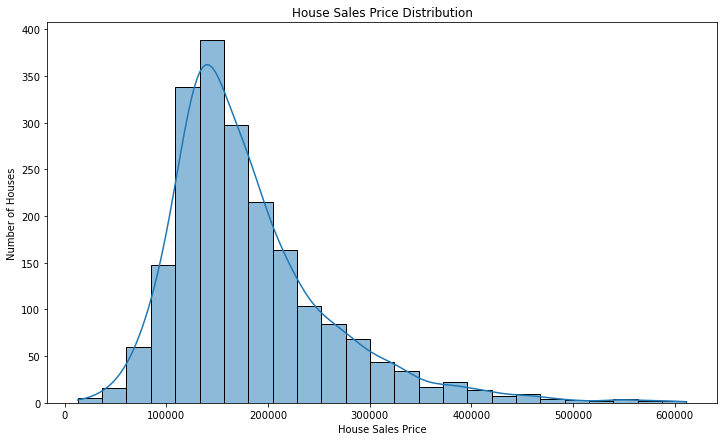

In [357]:
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(df['SalePrice'], bins = 25,kde=True)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution");

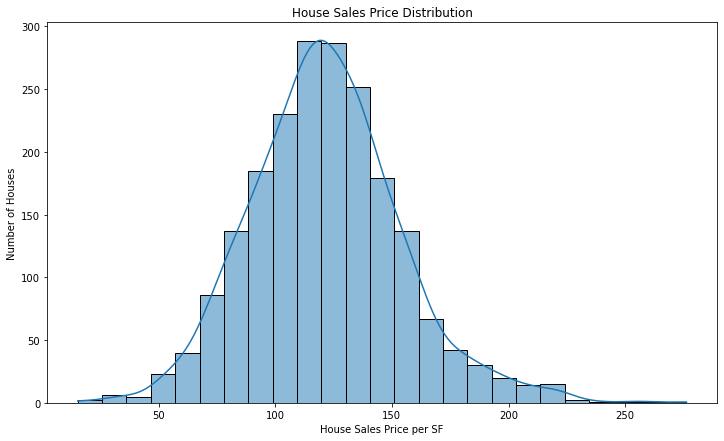

In [358]:
#price per sf
df['SalePricePerSF'] = df.loc[:,'SalePrice']/df.loc[:,'Gr Liv Area']
target=df['SalePricePerSF']
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(target, bins = 25,kde=True)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price per SF")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution");

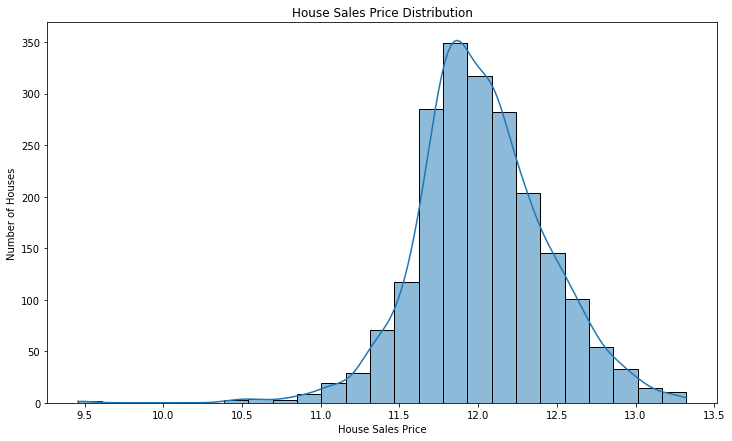

In [359]:
if is_y_logged:
    df['SalePrice'] = np.log(df['SalePrice'])
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(df['SalePrice'], bins = 25,kde=True)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution");

###  handling outliers

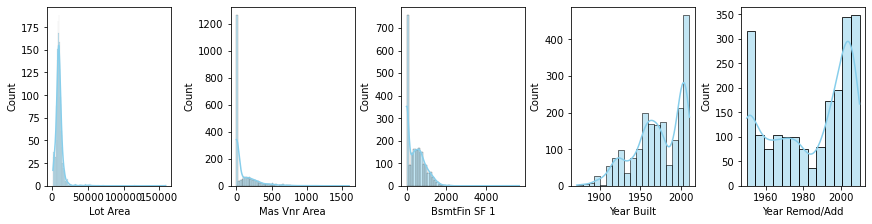

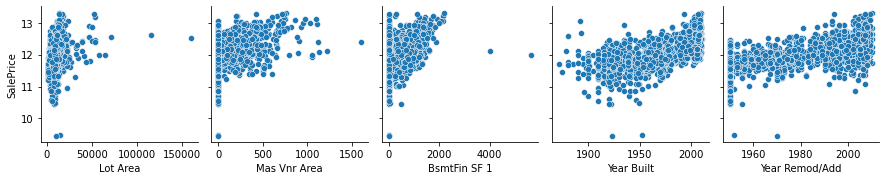

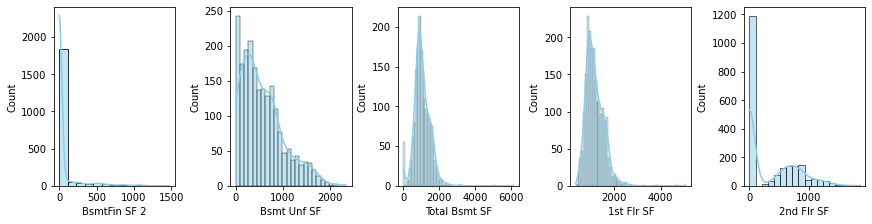

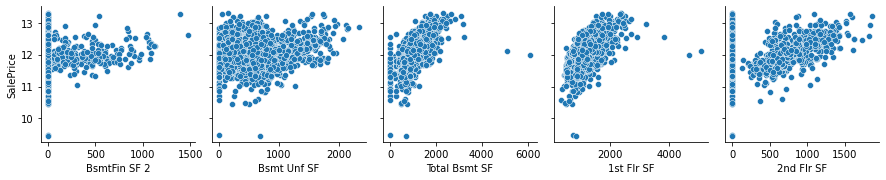

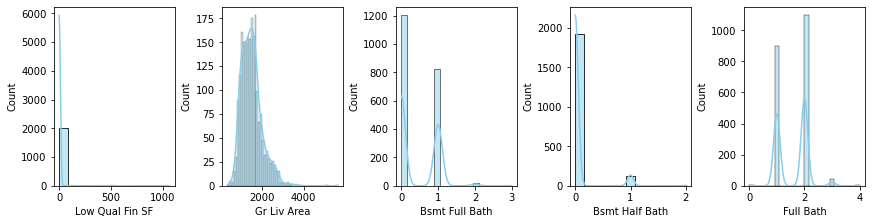

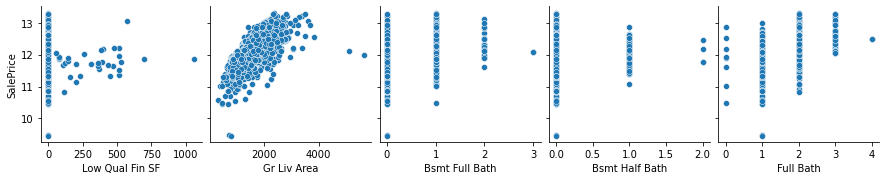

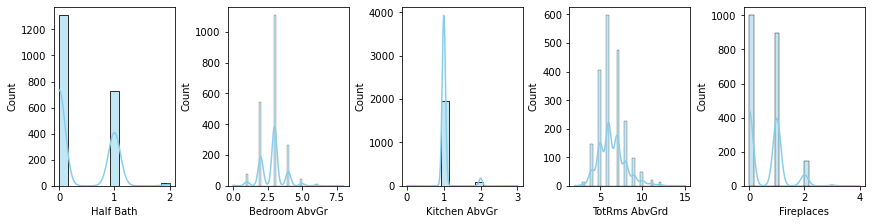

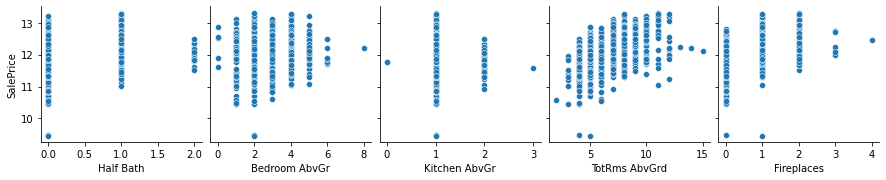

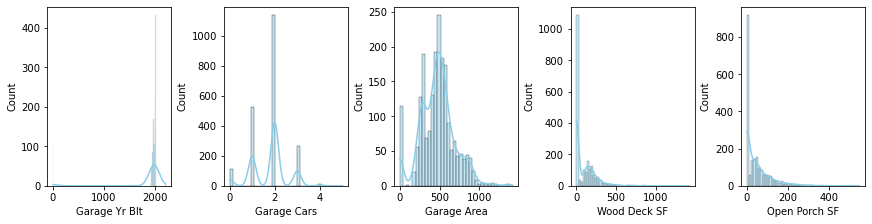

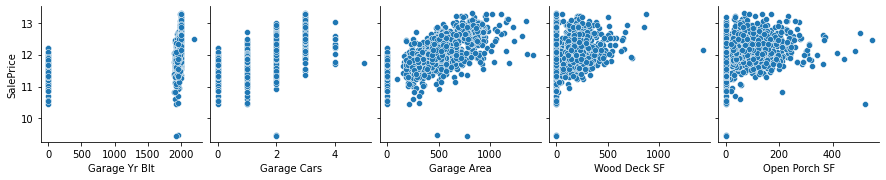

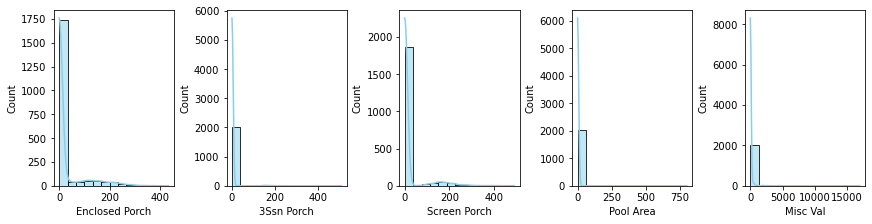

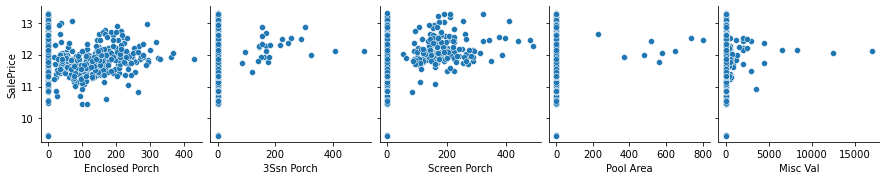

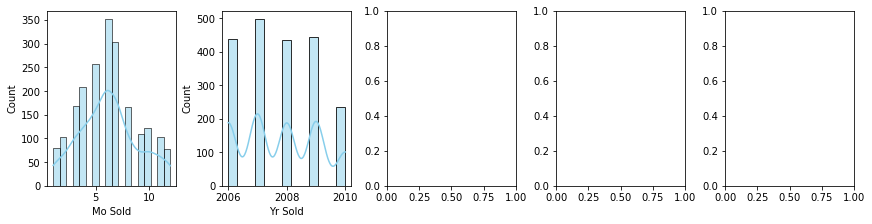

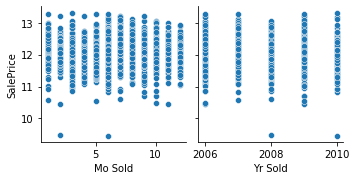

In [360]:
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=target_variable)
    i +=columns_in_a_row

In [361]:
#get_indexs_of_outliers_IQR(df, feature, cut_off_IQR, direction="both"):
    
outliers_index = get_indexs_of_outliers_IQR(df, features_numeric, 3, direction="upper")

print(len(outliers_index))


feature name: Lot Area
Percentiles: 25th=7500.000, 75th=11513.500, IQR=4013.500
{1542, 12, 1167, 913, 24, 1432, 1052, 160, 1571, 1701, 1964, 1843, 694, 823, 1080, 441, 1335, 1726, 1854, 960, 1090, 71, 841, 337, 1875, 471, 1885, 616, 745, 108, 1267, 245, 635, 125}
feature name: Mas Vnr Area
Percentiles: 25th=0.000, 75th=159.000, IQR=159.000
{257, 1409, 1671, 1416, 138, 1420, 1936, 1170, 281, 1692, 800, 1700, 682, 1835, 1964, 1581, 178, 1592, 1977, 960, 1604, 71, 199, 839, 1737, 1227, 1230, 81, 473, 987, 1117, 1885, 480, 230, 359, 1254, 489, 108, 623, 1647, 2041, 378, 125, 1151}
feature name: BsmtFin SF 1
Percentiles: 25th=0.000, 75th=733.500, IQR=733.500
{960, 1885}
feature name: Year Built
Percentiles: 25th=1953.500, 75th=2001.000, IQR=47.500
set()
feature name: Year Remod/Add
Percentiles: 25th=1964.500, 75th=2004.000, IQR=39.500
set()
feature name: BsmtFin SF 2
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
feature name: Bsmt Unf SF
Percentiles: 25th=220.000, 75th=811.000, IQR=591.000

In [362]:
#delete the outliers
print(df.shape)
df=df.drop(index=outliers_index)
print(df.shape)

(2051, 76)
(1932, 76)


### delete "salePrice" outliers

In [363]:
df[df["SalePrice"]<10]

Id        PID  MS SubClass  MS Zoning  Lot Area    Street  Lot Shape  \
183   1554  910251050     160000.0    47300.0     14584  163000.0   145000.0   
1628   182  902207130      99500.0   123900.0      9656  163000.0   145000.0   

      Land Contour  Utilities  Lot Config  Land Slope  Neighborhood  \
183       207000.0   162500.0    159000.0    188250.0      102000.0   
1628      161000.0   162500.0    159000.0    161000.0      120000.0   

      Condition 1  Condition 2  Bldg Type  House Style  Overall Qual  \
183      167000.0     163000.0   165200.0     156000.0       50150.0   
1628     167000.0     163000.0   165200.0     156000.0       57625.0   

      Overall Cond  Year Built  Year Remod/Add  Roof Style  Roof Matl  \
183       187593.5        1952            1952    159000.0   161500.0   
1628       71750.0        1923            1970    159000.0   161500.0   

      Exterior 1st  Exterior 2nd  Mas Vnr Type  Mas Vnr Area  Exter Qual  \
183       111000.0      203000.0      143950.0           0.0     83750.0   
1628      111000.0      111500.0      143950.0           0.0    139400.0   

      Exter Cond  Foundation  Bsmt Qual  Bsmt Cond  Bsmt Exposure  \
183      44800.0    102350.0   100000.0   100000.0       102350.0   
1628     92000.0    125500.0   100950.0   116500.0       150000.0   

      BsmtFin Type 1  BsmtFin SF 1  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  \
183         100000.0           0.0        100900.0           0.0          0.0   
1628        155835.0           0.0        167000.0           0.0        678.0   

      Total Bsmt SF   Heating  Heating QC  Central Air  Electrical  \
183             0.0   88750.0     87000.0      98000.0    122875.0   
1628          678.0  163500.0    134900.0      98000.0    170000.0   

      1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
183          733           0                0          733             0.0   
1628         832           0                0          832             0.0   

      Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
183              0.0          1          0              2              1   
1628             0.0          1          0              2              1   

      Kitchen Qual  TotRms AbvGrd  Functional  Fireplaces  Garage Type  \
183       100000.0              4     31550.0           0     185850.0   
1628      136500.0              5    165000.0           1     129500.0   

      Garage Yr Blt  Garage Finish  Garage Cars  Garage Area  Garage Qual  \
183          1952.0       135000.0          2.0        487.0     112000.0   
1628         1928.0       135000.0          2.0        780.0     112000.0   

      Garage Cond  Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  \
183      101950.0     105000.0             0              0               0   
1628     110000.0     105000.0             0              0               0   

      3Ssn Porch  Screen Porch  Pool Area  Misc Val  Mo Sold  Yr Sold  \
183            0             0          0         0        2     2008   
1628           0             0          0         0        6     2010   

      Sale Type  SalePrice  SalePricePerSF  
183    158500.0   9.480368       17.871760  
1628   158500.0   9.456341       15.371394

In [364]:
df= df.drop(df[df["SalePrice"]<10].index)

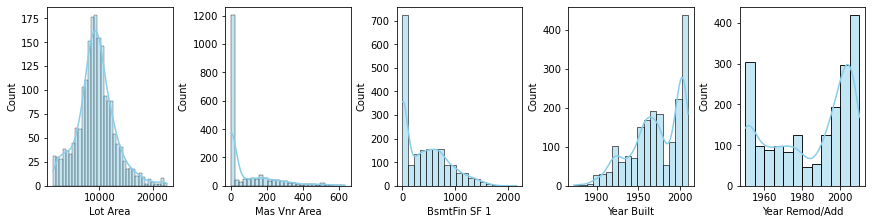

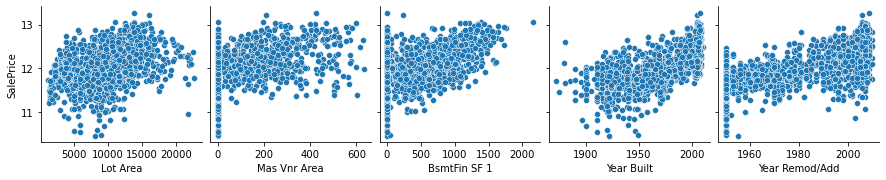

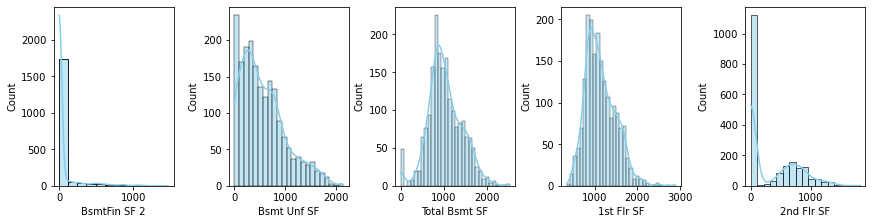

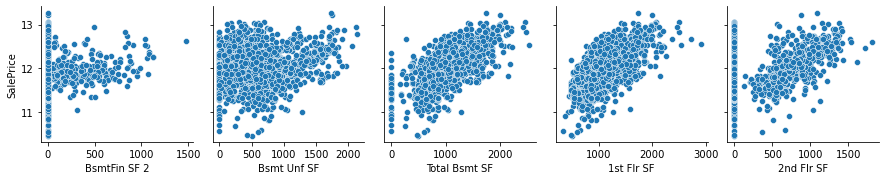

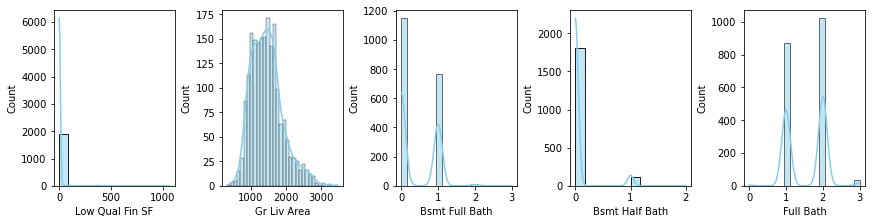

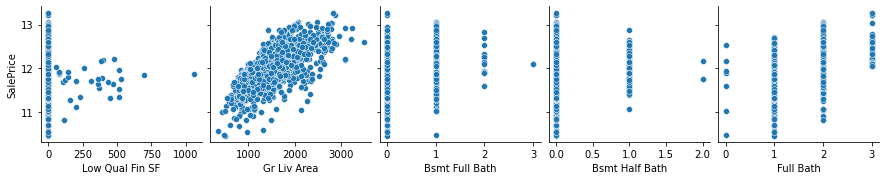

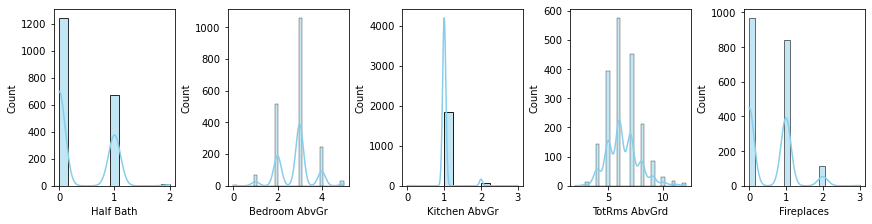

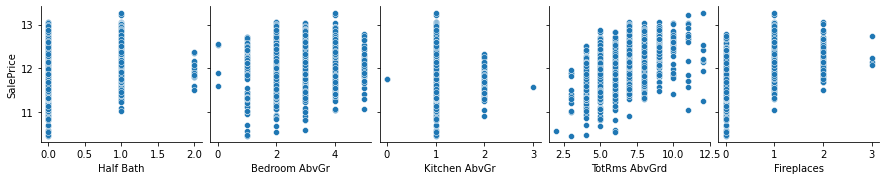

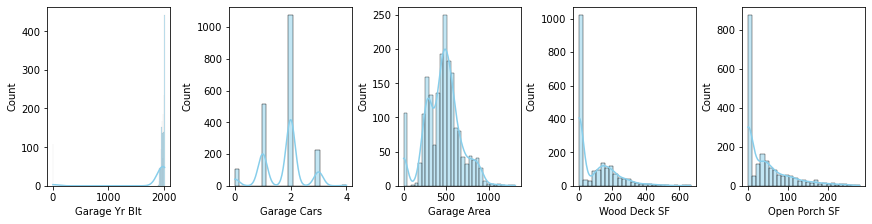

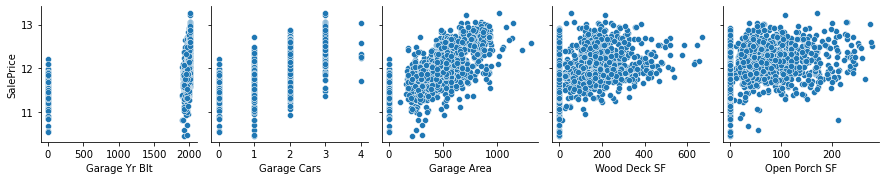

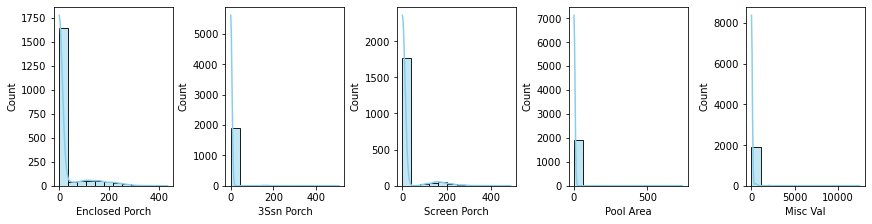

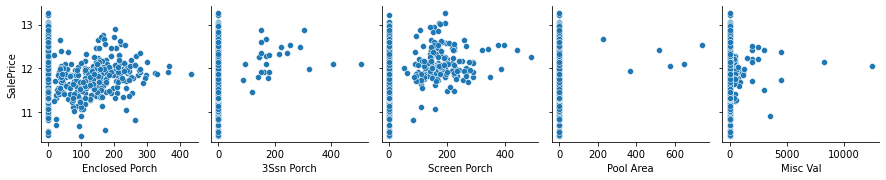

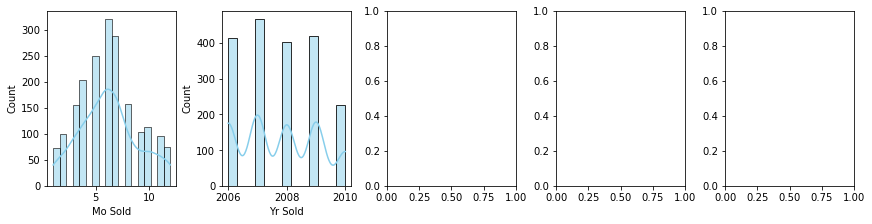

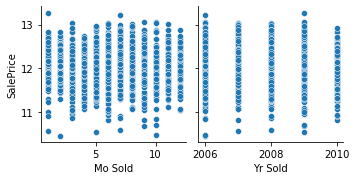

In [365]:
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=target_variable)
    i +=columns_in_a_row

### selecting numeric features

In [366]:
print(df.columns)
f=features_numeric + [target_variable]
print(f)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
   

In [367]:
#numeric_corr = df[features_numeric].corr()['SalePrice'].sort_values(ascending=False)

ls_corr = df[f].corr()[target_variable].sort_values(ascending=False)
df_corr = pd.DataFrame({"feature":ls_corr.index, "corr":ls_corr})
df_corr.reset_index(drop=True,inplace=True)
df_corr_filtered= df_corr[~df_corr['feature'].str.contains(target_variable)]
df_corr_filtered.head(100)

feature      corr
1       Gr Liv Area  0.701595
2       Garage Cars  0.683573
3       Garage Area  0.665143
4        Year Built  0.650624
5     Total Bsmt SF  0.643526
6        1st Flr SF  0.614924
7    Year Remod/Add  0.613220
8         Full Bath  0.573911
9     TotRms AbvGrd  0.494331
10       Fireplaces  0.470047
11     Mas Vnr Area  0.415532
12     BsmtFin SF 1  0.402781
13    Open Porch SF  0.392548
14         Lot Area  0.378498
15    Garage Yr Blt  0.342586
16     Wood Deck SF  0.334381
17        Half Bath  0.290404
18   Bsmt Full Bath  0.269294
19       2nd Flr SF  0.250613
20    Bedroom AbvGr  0.190793
21      Bsmt Unf SF  0.190215
22     Screen Porch  0.102593
23       3Ssn Porch  0.065599
24        Pool Area  0.036524
25          Mo Sold  0.033216
26     BsmtFin SF 2  0.018150
27         Misc Val -0.003073
28          Yr Sold -0.014912
29   Bsmt Half Bath -0.024370
30  Low Qual Fin SF -0.072937
31    Kitchen AbvGr -0.153378
32   Enclosed Porch -0.164592

<AxesSubplot:>

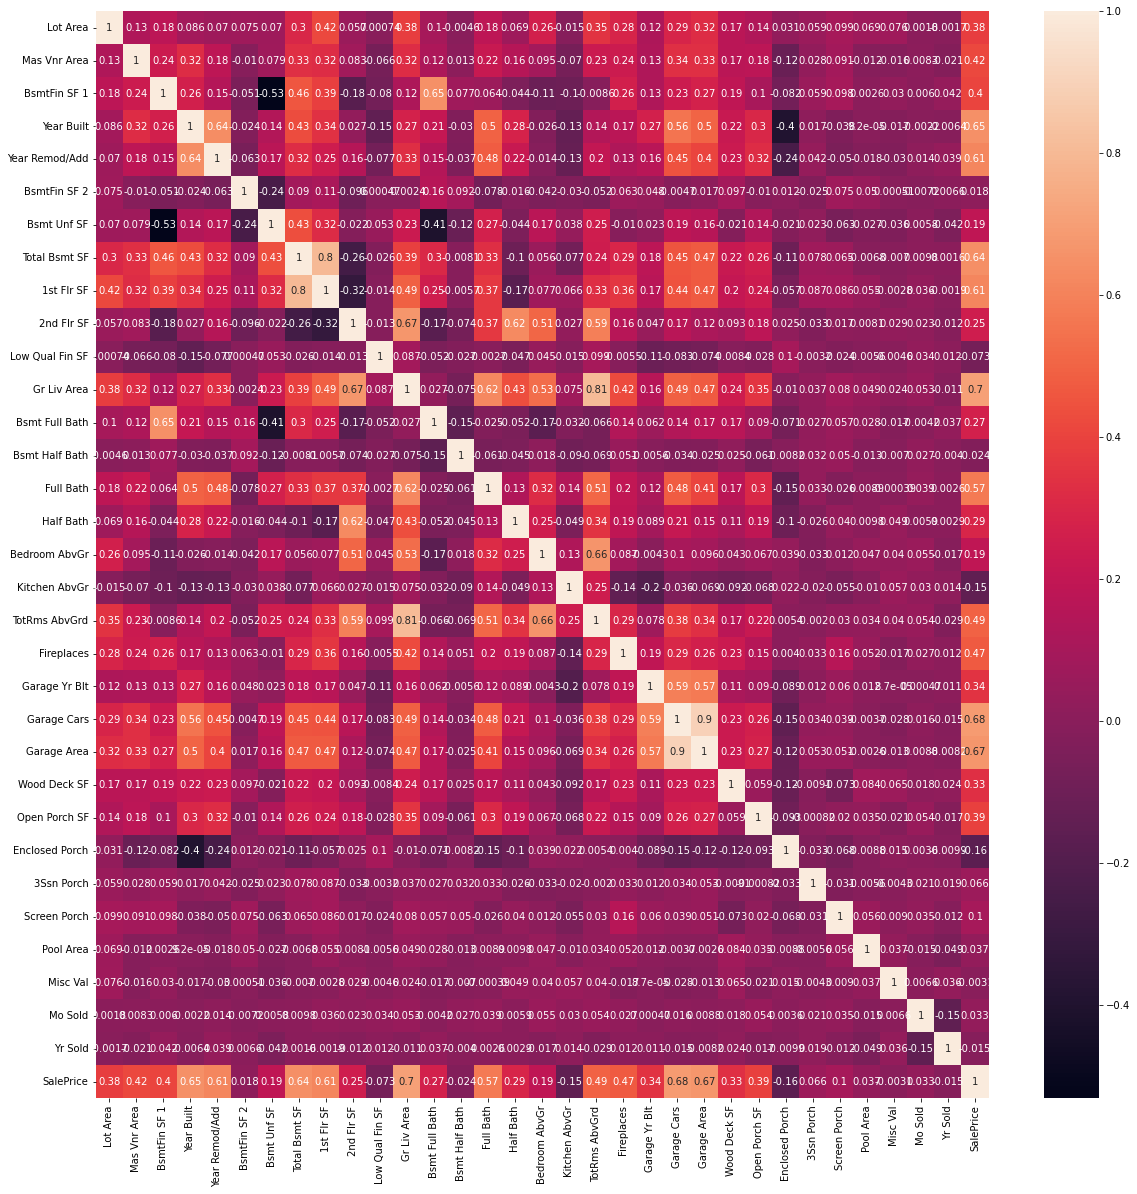

In [368]:
plt.figure(figsize=(20,20))
sns.heatmap(df[f].corr(), annot=True)

In [369]:
features_numeric_selected = df_corr_filtered.loc[np.abs(df_corr_filtered['corr'])>corr_threhold,['feature']].values
features_numeric_selected = [x[0] for x in features_numeric_selected]
print(features_numeric_selected)


['Gr Liv Area', 'Garage Cars', 'Garage Area', 'Year Built', 'Total Bsmt SF', '1st Flr SF', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Mas Vnr Area', 'BsmtFin SF 1']


### selecting features_ordinal

In [370]:
print(df.columns)
f=features_ordinal + [target_variable]
print(f)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
   

In [371]:
#numeric_corr = df[features_numeric].corr()['SalePrice'].sort_values(ascending=False)

df_ordinal=df[f]
ls_corr = df_ordinal.corr()[target_variable].sort_values(ascending=False)
df_corr = pd.DataFrame({"feature":ls_corr.index, "corr":ls_corr})
df_corr.reset_index(drop=True,inplace=True)
df_corr_filtered= df_corr[~df_corr['feature'].str.contains(target_variable)]
df_corr_filtered.head(100)

feature      corr
1     Overall Qual  0.797328
2        Bsmt Qual  0.675307
3       Exter Qual  0.671770
4     Kitchen Qual  0.665036
5    Garage Finish  0.626424
6       Heating QC  0.507632
7   BsmtFin Type 1  0.501811
8     Overall Cond  0.469985
9    Bsmt Exposure  0.396857
10     Paved Drive  0.391324
11     Garage Cond  0.385927
12     Garage Qual  0.372035
13      Electrical  0.326793
14       Lot Shape  0.323472
15       Bsmt Cond  0.306679
16      Exter Cond  0.238172
17  BsmtFin Type 2  0.216127
18      Functional  0.188375
19       Utilities  0.062281
20      Land Slope  0.008928

<AxesSubplot:>

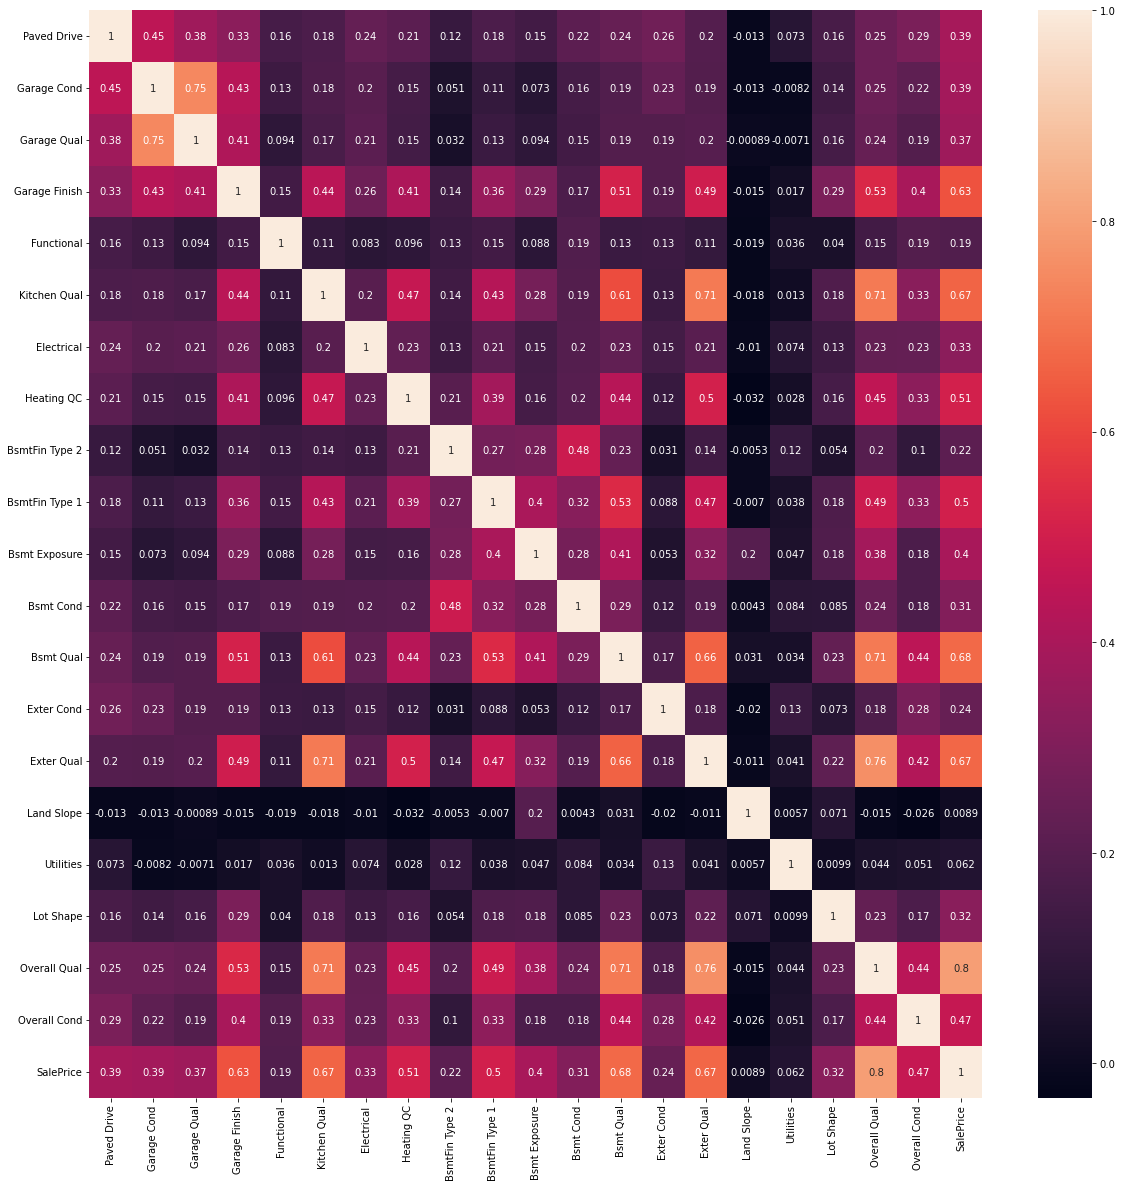

In [372]:
plt.figure(figsize=(20,20))
sns.heatmap(df[f].corr(), annot=True)

In [373]:
features_ordinal_selected = df_corr_filtered.loc[np.abs(df_corr_filtered['corr'])>corr_threhold,['feature']].values
features_ordinal_selected = [x[0] for x in features_ordinal_selected ]
print(features_ordinal_selected)


['Overall Qual', 'Bsmt Qual', 'Exter Qual', 'Kitchen Qual', 'Garage Finish', 'Heating QC', 'BsmtFin Type 1', 'Overall Cond']


### selecting features_categorical

In [374]:
print(df.columns)
f=features_categorical + [target_variable]
print(f)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
   

In [375]:
#numeric_corr = df[features_numeric].corr()['SalePrice'].sort_values(ascending=False)

df_categorical=df[f]
ls_corr = df_categorical.corr()[target_variable].sort_values(ascending=False)
df_corr = pd.DataFrame({"feature":ls_corr.index, "corr":ls_corr})
df_corr.reset_index(drop=True,inplace=True)
df_corr_filtered= df_corr[~df_corr['feature'].str.contains(target_variable)]
df_corr_filtered.head(100)

feature      corr
1   Neighborhood  0.742861
2    Garage Type  0.593053
3     Foundation  0.584848
4    MS SubClass  0.582151
5   Exterior 1st  0.441334
6   Mas Vnr Type  0.433325
7   Exterior 2nd  0.432693
8      MS Zoning  0.427449
9    Central Air  0.384872
10     Sale Type  0.339051
11   House Style  0.289124
12   Condition 1  0.242346
13     Bldg Type  0.234395
14    Roof Style  0.188333
15  Land Contour  0.173317
16       Heating  0.155482
17    Lot Config  0.134307
18   Condition 2  0.133831
19        Street  0.111167
20     Roof Matl  0.070199

<AxesSubplot:>

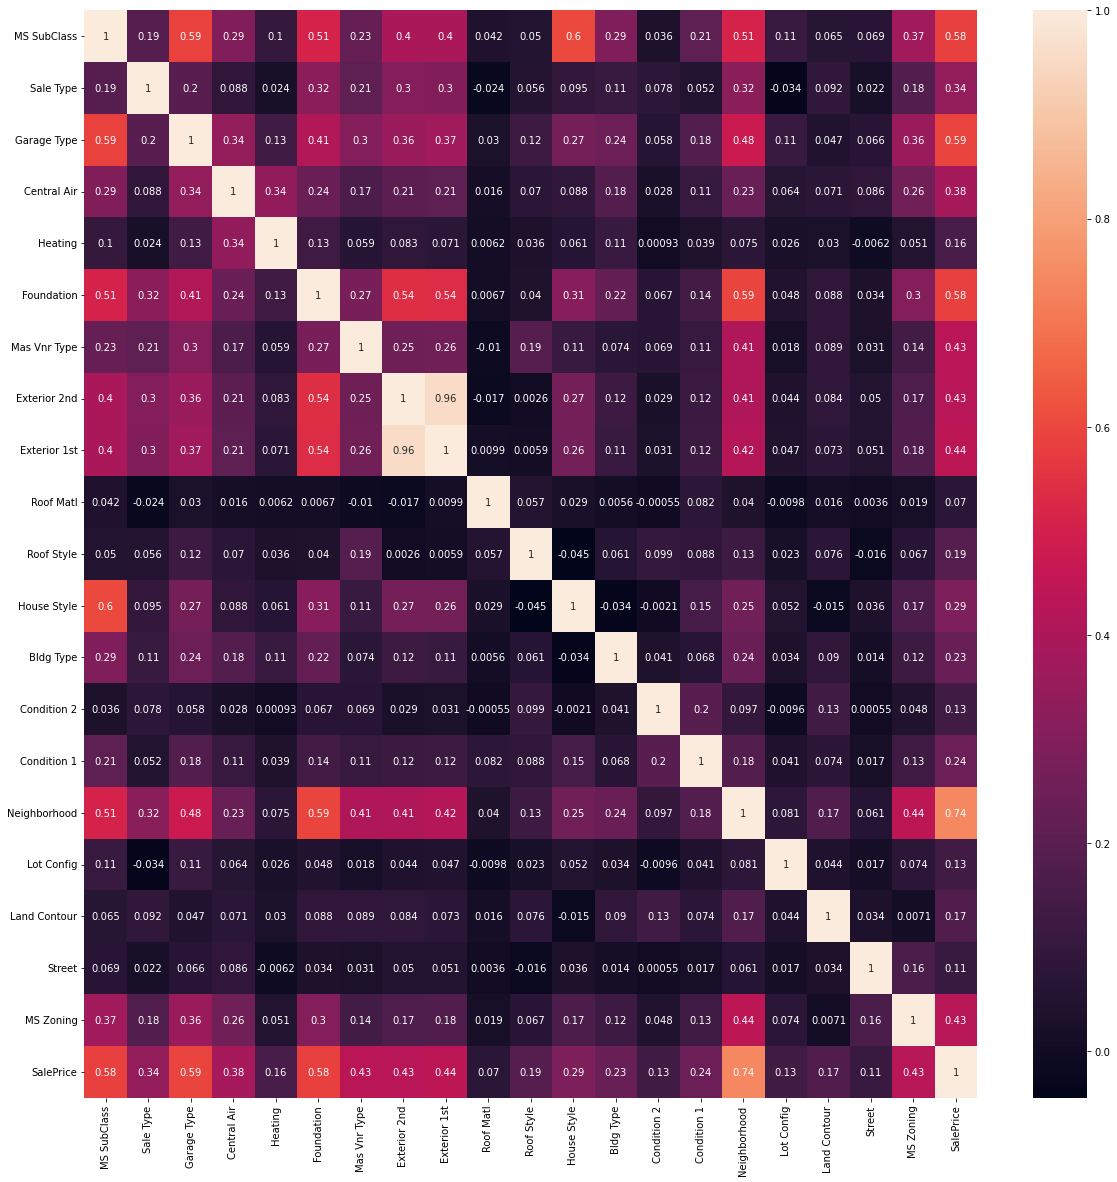

In [376]:
plt.figure(figsize=(20,20))
sns.heatmap(df[f].corr(), annot=True)

In [377]:
features_categorical_selected = df_corr_filtered.loc[np.abs(df_corr_filtered['corr'])>corr_threhold,['feature']].values
features_categorical_selected = [x[0] for x in features_categorical_selected ]
print(features_categorical_selected)


['Neighborhood', 'Garage Type', 'Foundation', 'MS SubClass', 'Exterior 1st', 'Mas Vnr Type', 'Exterior 2nd', 'MS Zoning']


##### Preparing features_final

In [378]:
# testing
features_final = features_numeric_selected + features_ordinal_selected + features_categorical_selected
features_all = features_numeric + features_ordinal + features_categorical
print(features_final)

['Gr Liv Area', 'Garage Cars', 'Garage Area', 'Year Built', 'Total Bsmt SF', '1st Flr SF', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Mas Vnr Area', 'BsmtFin SF 1', 'Overall Qual', 'Bsmt Qual', 'Exter Qual', 'Kitchen Qual', 'Garage Finish', 'Heating QC', 'BsmtFin Type 1', 'Overall Cond', 'Neighborhood', 'Garage Type', 'Foundation', 'MS SubClass', 'Exterior 1st', 'Mas Vnr Type', 'Exterior 2nd', 'MS Zoning']


##### checking multicollinearity of features_final

In [388]:
print(features_all)

['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape', 'Overall Qual', 'Overall Cond', 'MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 

In [389]:
X_all = df[features_all]
y = df[target_variable]
features_final=forward_selection(X,y)
print(features_final)

C:\Users\olive\AppData\Local\Temp/ipykernel_14232/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_14232/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-

['Overall Qual', 'Gr Liv Area', 'Year Built', 'BsmtFin SF 1', 'MS Zoning', 'Year Remod/Add', 'Total Bsmt SF', 'Fireplaces', 'Garage Area', 'Garage Type', 'Heating QC', 'Neighborhood', 'Kitchen Qual', 'Overall Cond', 'MS SubClass', '1st Flr SF', 'Garage Cars']


C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_14232/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-

#### get best classifier

In [390]:
X = df[features_final]
X.head()
y = df[target_variable]
best_gs = get_best_gridSearchCV(X,y)


best performing model: {'classifier': Ridge(alpha=16.297508346206442), 'classifier__alpha': 16.297508346206442}
Mse score:  0.015899835578425683
mse of train data:  441436027.97070855
mse of test data:  528034536.96015745
diff%:  -19.617453833014995%
best performing model: {'classifier': Ridge(alpha=16.297508346206442), 'classifier__alpha': 16.297508346206442}
Mse score:  0.016429531613327865
mse of train data:  469538225.8165646
mse of test data:  467562705.6267875
diff%:  0.42073681782597105%
random key:  1
{1: 467562705.6267875}


In [391]:
type(best_gs)

sklearn.model_selection._search.GridSearchCV

In [392]:
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)       


feature      coef  abs_coef
0      Gr Liv Area  0.124541  0.124541
1     Overall Qual  0.085110  0.085110
2   Year Remod/Add  0.074967  0.074967
3     BsmtFin SF 1  0.073896  0.073896
4       Fireplaces  0.052508  0.052508
5    Total Bsmt SF  0.046881  0.046881
6       Heating QC  0.046158  0.046158
7      Garage Type  0.044496  0.044496
8      MS SubClass  0.033550  0.033550
9     Neighborhood  0.030113  0.030113
10     Garage Area  0.028770  0.028770
11      1st Flr SF  0.025557  0.025557
12    Kitchen Qual  0.024760  0.024760
13     Garage Cars  0.022563  0.022563
14    Overall Cond  0.018265  0.018265
15      Year Built  0.010339  0.010339
16       MS Zoning  0.000001  0.000001

# Multicollinearity

In [393]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features_final

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

           feature           VIF
0     Overall Qual     30.980956
1      Gr Liv Area     25.717010
2       Year Built  12241.970656
3     BsmtFin SF 1      2.710816
4        MS Zoning     82.165137
5   Year Remod/Add  11202.472066
6    Total Bsmt SF     26.315887
7       Fireplaces      2.551005
8      Garage Area     33.322267
9      Garage Type     55.029301
10      Heating QC     49.324703
11    Neighborhood     28.681630
12    Kitchen Qual     28.458246
13    Overall Cond     61.445591
14     MS SubClass     64.861894
15      1st Flr SF     41.041546
16     Garage Cars     37.948145


In [394]:
df_coefs = pd.merge(df_coefs, vif_data, on='feature')
df_coefs.head(100)

feature      coef  abs_coef           VIF
0      Gr Liv Area  0.124541  0.124541     25.717010
1     Overall Qual  0.085110  0.085110     30.980956
2   Year Remod/Add  0.074967  0.074967  11202.472066
3     BsmtFin SF 1  0.073896  0.073896      2.710816
4       Fireplaces  0.052508  0.052508      2.551005
5    Total Bsmt SF  0.046881  0.046881     26.315887
6       Heating QC  0.046158  0.046158     49.324703
7      Garage Type  0.044496  0.044496     55.029301
8      MS SubClass  0.033550  0.033550     64.861894
9     Neighborhood  0.030113  0.030113     28.681630
10     Garage Area  0.028770  0.028770     33.322267
11      1st Flr SF  0.025557  0.025557     41.041546
12    Kitchen Qual  0.024760  0.024760     28.458246
13     Garage Cars  0.022563  0.022563     37.948145
14    Overall Cond  0.018265  0.018265     61.445591
15      Year Built  0.010339  0.010339  12241.970656
16       MS Zoning  0.000001  0.000001     82.165137

<AxesSubplot:>

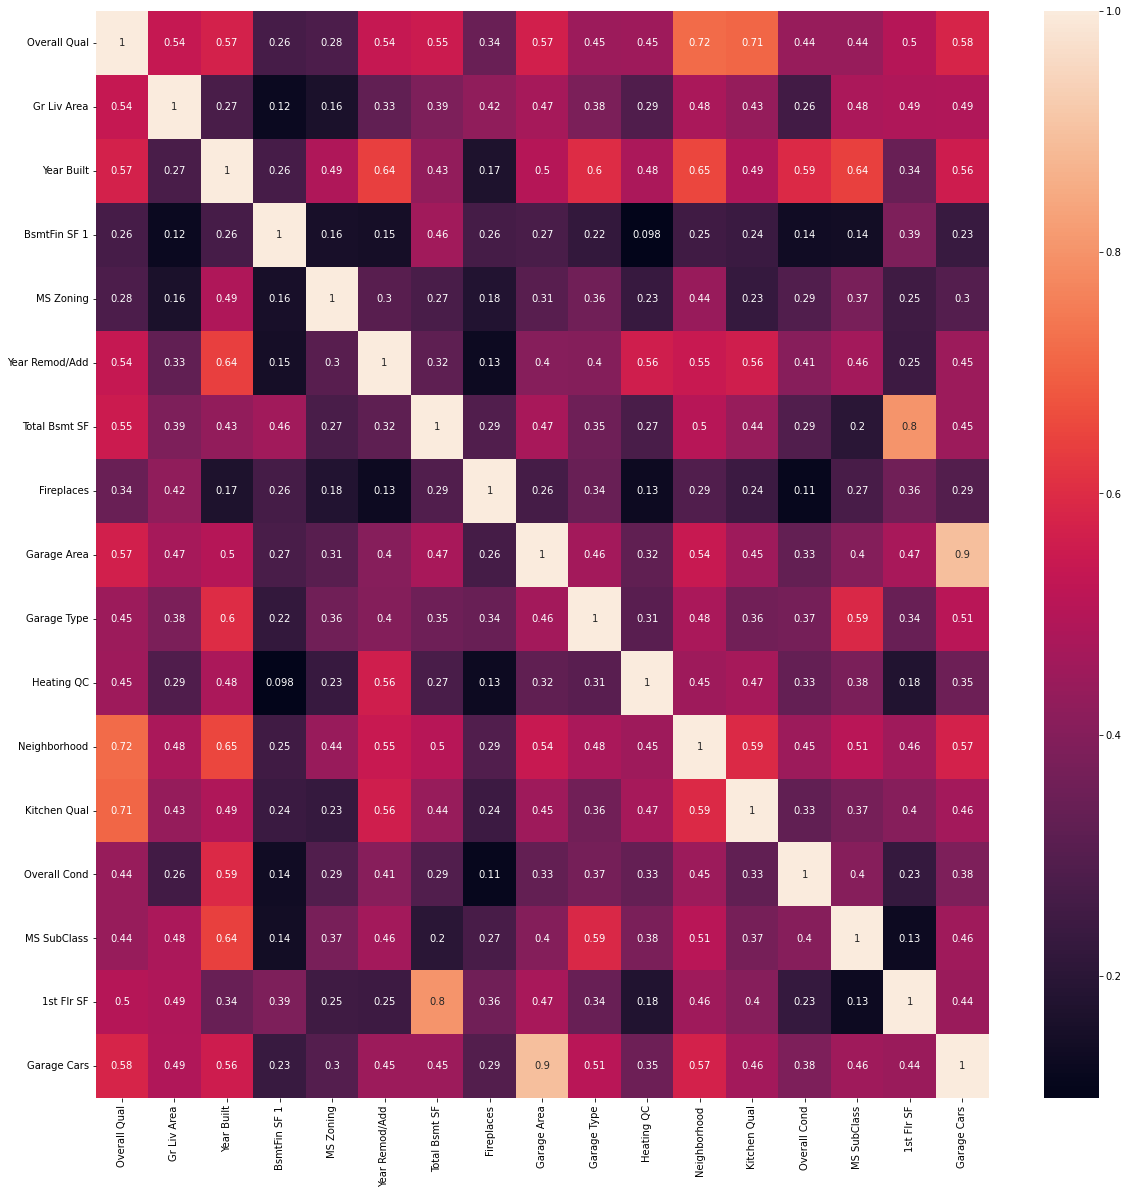

In [395]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), annot=True)

In [396]:
s = X.corr().unstack()
#s.sort_values(kind="quicksort")
s[(abs(s)>0.6) & (abs(s) < 1)]

Overall Qual    Neighborhood      0.721323
                Kitchen Qual      0.710944
Year Built      Year Remod/Add    0.637738
                Neighborhood      0.654667
                MS SubClass       0.641534
Year Remod/Add  Year Built        0.637738
Total Bsmt SF   1st Flr SF        0.801716
Garage Area     Garage Cars       0.897360
Neighborhood    Overall Qual      0.721323
                Year Built        0.654667
Kitchen Qual    Overall Qual      0.710944
MS SubClass     Year Built        0.641534
1st Flr SF      Total Bsmt SF     0.801716
Garage Cars     Garage Area       0.897360
dtype: float64

In [230]:
features_to_remove=['Full Bath', 'TotRms AbvGrd',
                    'Garage Cars','Overall Qual',
                    'Garage Type','1st Flr SF'
                   ]

In [231]:
features_final = list(set(features_final) - set(features_to_remove))

print(features_final)

['Garage Finish', 'Kitchen Qual', 'Overall Cond', 'Gr Liv Area', 'Neighborhood', 'Garage Area', 'Foundation', 'Fireplaces', 'Total Bsmt SF', 'Heating QC', 'MS SubClass', 'BsmtFin SF 1', 'MS Zoning']


In [232]:
X = df[features_final]
X.head()
y = df[target_variable]
best_gs = get_best_gridSearchCV(X,y)


best performing model: {'classifier': Ridge(alpha=25.95024211399736), 'classifier__alpha': 25.95024211399736}
Mse score:  0.019777353606044795
mse of train data:  561930497.2881608
mse of test data:  609408655.3331921
diff%:  -8.449115731243943%
best performing model: {'classifier': Ridge(alpha=23.101297000831593), 'classifier__alpha': 23.101297000831593}
Mse score:  0.01919210265474559
mse of train data:  575024057.4050994
mse of test data:  561333027.0134699
diff%:  2.3809491473126743%
best performing model: {'classifier': Ridge(alpha=11.497569953977356), 'classifier__alpha': 11.497569953977356}
Mse score:  0.02012932394693353
mse of train data:  549314493.2092987
mse of test data:  638454466.7380649
diff%:  -16.227493472450984%
best performing model: {'classifier': Ridge(alpha=25.95024211399736), 'classifier__alpha': 25.95024211399736}
Mse score:  0.01980901248602652
mse of train data:  542369734.1947006
mse of test data:  662081194.9227325
diff%:  -22.07192864582995%
best performin

In [234]:
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)       


feature      coef  abs_coef
0     Gr Liv Area  0.141688  0.141688
1   Total Bsmt SF  0.072531  0.072531
2    Kitchen Qual  0.070526  0.070526
3    BsmtFin SF 1  0.065749  0.065749
4    Neighborhood  0.061727  0.061727
5     Garage Area  0.060927  0.060927
6      Fireplaces  0.059185  0.059185
7      Heating QC  0.058750  0.058750
8     MS SubClass  0.043332  0.043332
9   Garage Finish  0.039974  0.039974
10   Overall Cond  0.038276  0.038276
11     Foundation  0.031824  0.031824
12      MS Zoning  0.000002  0.000002

# Multicollinearity

In [236]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features_final

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

          feature        VIF
0   Garage Finish  42.750670
1    Kitchen Qual  23.131434
2    Overall Cond  51.733533
3     Gr Liv Area  20.516142
4    Neighborhood  23.673922
5     Garage Area  10.551622
6      Foundation  48.655422
7      Fireplaces   2.464656
8   Total Bsmt SF  14.450310
9      Heating QC  47.658070
10    MS SubClass  54.589777
11   BsmtFin SF 1   2.691367
12      MS Zoning  49.281816


In [237]:
df_coefs = pd.merge(df_coefs, vif_data, on='feature')
df_coefs.head(100)

feature      coef  abs_coef        VIF
0     Gr Liv Area  0.141688  0.141688  20.516142
1   Total Bsmt SF  0.072531  0.072531  14.450310
2    Kitchen Qual  0.070526  0.070526  23.131434
3    BsmtFin SF 1  0.065749  0.065749   2.691367
4    Neighborhood  0.061727  0.061727  23.673922
5     Garage Area  0.060927  0.060927  10.551622
6      Fireplaces  0.059185  0.059185   2.464656
7      Heating QC  0.058750  0.058750  47.658070
8     MS SubClass  0.043332  0.043332  54.589777
9   Garage Finish  0.039974  0.039974  42.750670
10   Overall Cond  0.038276  0.038276  51.733533
11     Foundation  0.031824  0.031824  48.655422
12      MS Zoning  0.000002  0.000002  49.281816

<AxesSubplot:>

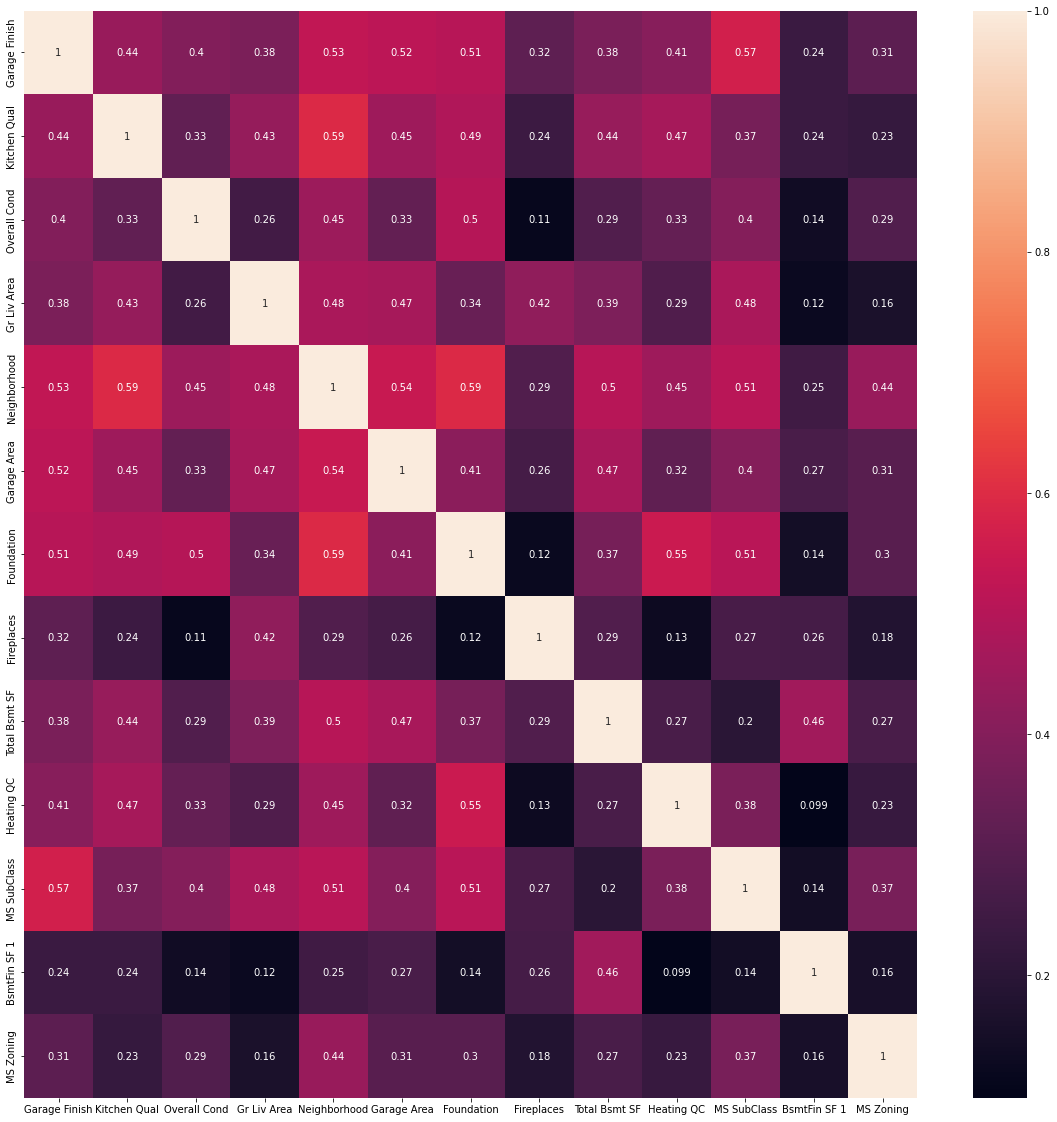

In [238]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), annot=True)

## Kaggle 

In [239]:
df_kaggle = pd.read_csv("../datasets/test_modified.csv")
df_kaggle.shape             

(878, 77)

In [240]:
X_kaggle=df_kaggle[features_final]
X_kaggle.head()

Garage Finish  Kitchen Qual  Overall Cond  Gr Liv Area  Neighborhood  \
0       135000.0      100000.0      144000.0         1928      120000.0   
1       215000.0      136500.0      110479.5         1967      135000.0   
2       190550.0      200912.5      187593.5         1496      180750.0   
3       135000.0      136500.0      142500.0          968      120000.0   
4       190550.0      136500.0      187593.5         1394      141000.0   

   Garage Area  Foundation  Fireplaces  Total Bsmt SF  Heating QC  \
0        440.0    118000.0           0         1020.0    153000.0   
1        580.0    140750.0           0         1967.0    134900.0   
2        426.0    209000.0           1          654.0    197000.0   
3        480.0    140750.0           0          968.0    134900.0   
4        514.0    140750.0           2         1394.0    153000.0   

   MS SubClass  BsmtFin SF 1  MS Zoning  
0     123250.0           0.0   123900.0  
1     136000.0           0.0   172500.0  
2     215100.0         554.0   172500.0  
3      99500.0           0.0   123900.0  
4     160000.0         609.0   172500.0

In [118]:
X_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gr Liv Area     878 non-null    int64  
 1   Garage Cars     878 non-null    float64
 2   Garage Area     878 non-null    float64
 3   Total Bsmt SF   878 non-null    float64
 4   1st Flr SF      878 non-null    int64  
 5   Full Bath       878 non-null    int64  
 6   TotRms AbvGrd   878 non-null    int64  
 7   Fireplaces      878 non-null    int64  
 8   Mas Vnr Area    878 non-null    float64
 9   BsmtFin SF 1    878 non-null    float64
 10  Overall Qual    878 non-null    float64
 11  Bsmt Qual       878 non-null    float64
 12  Exter Qual      878 non-null    float64
 13  Kitchen Qual    878 non-null    float64
 14  Garage Finish   878 non-null    float64
 15  Heating QC      878 non-null    float64
 16  BsmtFin Type 1  878 non-null    float64
 17  Overall Cond    878 non-null    flo

In [119]:
X_kaggle.isnull().sum()

Gr Liv Area       0
Garage Cars       0
Garage Area       0
Total Bsmt SF     0
1st Flr SF        0
Full Bath         0
TotRms AbvGrd     0
Fireplaces        0
Mas Vnr Area      0
BsmtFin SF 1      0
Overall Qual      0
Bsmt Qual         0
Exter Qual        0
Kitchen Qual      0
Garage Finish     0
Heating QC        0
BsmtFin Type 1    0
Overall Cond      0
Neighborhood      0
Garage Type       0
Foundation        0
MS SubClass       0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
MS Zoning         0
dtype: int64

<AxesSubplot:ylabel='Count'>

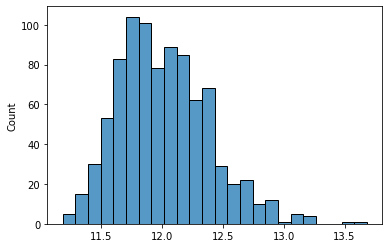

In [241]:
target_kaggle =best_gs.predict(X_kaggle)
sns.histplot(target_kaggle)

##### depend on target_variable, calculate 

In [242]:
print(target_variable)

SalePrice


In [243]:
if target_variable == "SalePrice":
    if is_y_logged:
        df_kaggle['SalePrice'] = np.exp(target_kaggle)
    else:
        df_kaggle['SalePrice'] = target_kaggle
    #df_kaggle['SalePrice'] = y_kaggle
elif target_variable == "SalePricePerSF":
    df_kaggle['SalePrice'] = target_kaggle *  df_kaggle['Gr Liv Area']

In [244]:
df_submission = df_kaggle.loc[:,['Id','SalePrice']]

In [245]:
df_submission.head(100)

Id      SalePrice
0   2658  123577.999693
1   2718  175894.705863
2   2414  189128.116748
3   1989   99449.458440
4    625  180152.901868
5    333   95314.240674
6   1327  101789.687211
7    858  141630.092018
8     95  196634.783855
9   1568  156057.559542
10  2482  169452.187854
11  1364   98844.961170
12  2584  156980.923540
13   818  296483.817206
14  2673  136084.130116
15  2089  123188.827937
16  1297  144217.896046
17   790  122187.214759
18  2616  185701.082232
19   720  145374.057588
20   222  139473.097403
21   557  131491.978770
22  1148  219108.535927
23  2766  170807.726938
24   534  164487.643779
25  1452  117263.307910
26   630  132608.932690
27  2648  137037.376926
28   125  152753.123513
29  1904   83979.560429
30  1670  119147.373512
31   756  107741.436311
32   717  198201.936146
33  1032  165089.065779
34   852  207327.095126
35  1731  170552.691338
36  2639  124262.190594
37  2071   97465.374409
38  1267  106044.769136
39  1851  193102.963196
40   567  167797.410302
41  2439  201115.829017
42  1898  149417.230030
43   647  154986.811692
44  2256  232151.076616
45   979   95887.601015
46  1444  222415.439276
47  2485  121492.766515
48   157  125864.824592
49    88  132204.780394
50  2003  109464.533153
51   186  151977.901889
52  1425  230146.352761
53  2695  117336.805321
54   738  108447.150872
55   395  138513.775812
56  1353  147515.154391
57  1878  146640.360021
58   390  150493.046510
59  1456  247270.130710
60  1103  352702.880027
61  1387  133412.015269
62  2070  136613.978341
63  1199  161476.099992
64  2479  185515.875805
65   501  324882.257693
66  2362   99825.039066
67  1718  241737.879155
68  2188   97800.116681
69  1483  155519.820166
70  2557  107512.740855
71   437  404557.043212
72  2224  199167.973927
73  1628  157169.130764
74   397  127931.912255
75   587  189973.865048
76   971  120446.342117
77  2611  146085.892190
78  1887   95472.754852
79  2399  356642.444193
80  2148  200462.673983
81   304  105921.850133
82  1997  124636.948146
83  2817  126031.202953
84  1431  190904.490916
85   427  388837.319258
86   263  122411.411865
87   598  166355.617271
88  2895  182924.943299
89   687  130095.242127
90  1822  127499.015523
91  2191  113799.165738
92   179  100658.815230
93  1009  216608.248491
94  2010  109608.847530
95  1991  122708.564970
96  1411  167668.801826
97  1721  242716.026577
98  1144  198653.902404
99   593  192893.847045

In [246]:
df_submission.to_csv("../datasets/submission.csv",index=False)

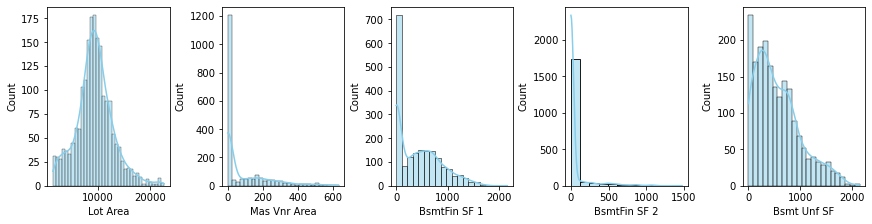

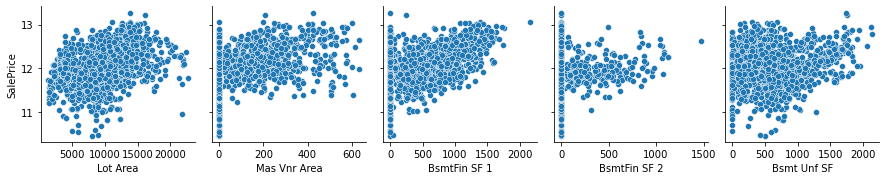

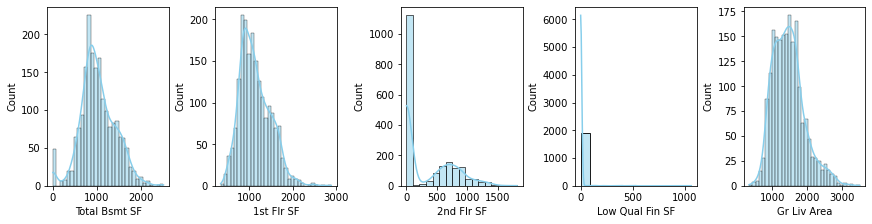

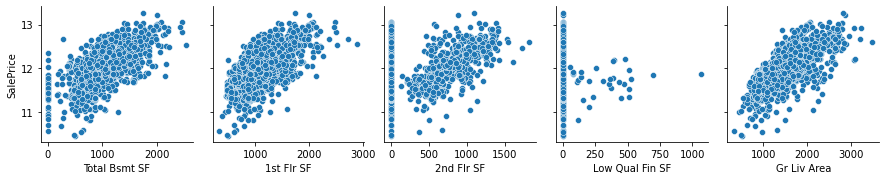

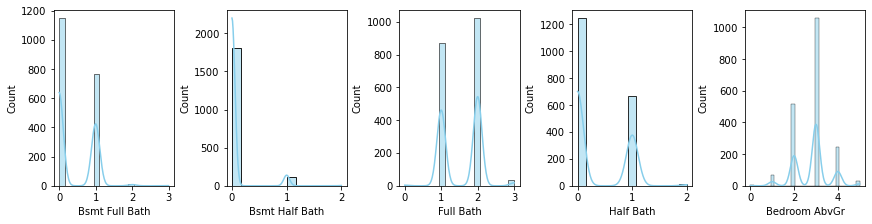

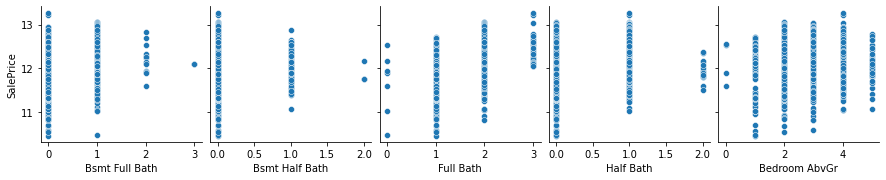

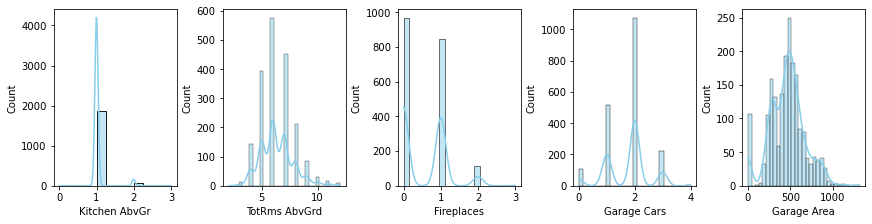

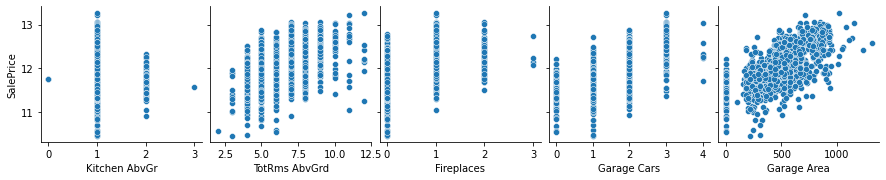

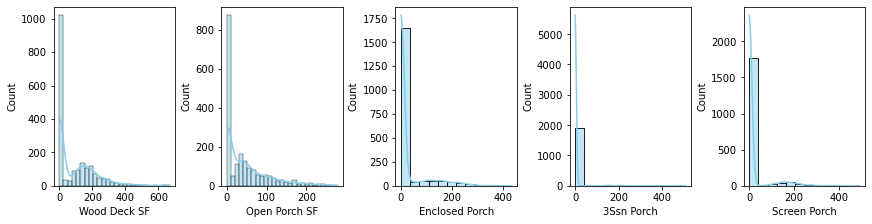

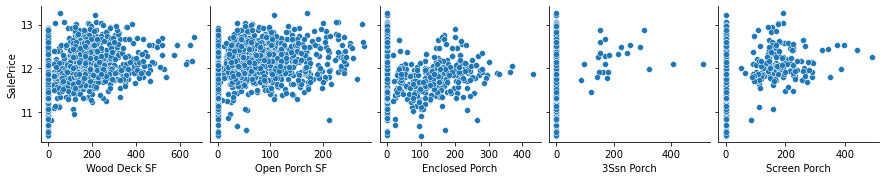

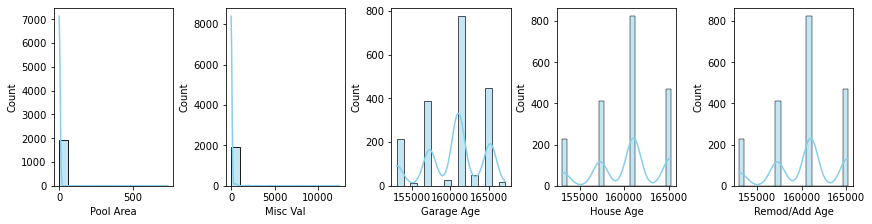

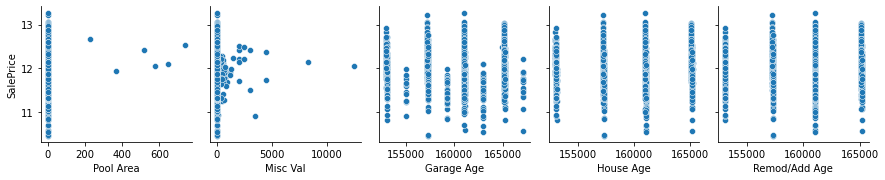

In [247]:

#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=target_variable)
    i +=columns_in_a_row


In [ ]:

#plot the histogram of each ordinal feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_ordinal)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_ordinal)):
            sns.histplot(data=df, x=features_ordinal[i+j], kde=True, color="skyblue", ax=axs[j])
#    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row

In [ ]:

#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_categorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            sns.histplot(data=df, x=features_categorical[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row

In [ ]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row
'''

In [ ]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
            df[features_numeric[i+j]].value_counts(dropna=False).plot(title=features_numeric[i+j], kind='hist',ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row
'''

In [ ]:

#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_categorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            sns.histplot(data=df, x=features_categorical[i+j], kde=True, color="skyblue", ax=axs[j])
      
    sns.pairplot(df, x_vars=features_categorical[i:min(i+columns_in_a_row,len(features_categorical))], y_vars=["saleprice"])
    sns.boxplot(x="ms_subclass", y="saleprice", data=df)
    i +=columns_in_a_row
    


# polynomial

In [ ]:
poly = PolynomialFeatures(include_bias=False,interaction_only=False)

df_poly=pd.DataFrame(poly.fit_transform(df[features_numeric]),
                     columns=poly.get_feature_names(features_numeric))
df_poly.shape


In [ ]:
df.shape

In [ ]:
df_poly["SalePrice"]=df["SalePrice"]

In [ ]:
#numeric_corr = df[features_numeric].corr()['SalePrice'].sort_values(ascending=False)

ls_corr = df_poly.corr()['SalePrice'].sort_values(ascending=False)
df_corr = pd.DataFrame({"feature":ls_corr.index, "corr":ls_corr})
df_corr['abs_corr'] = np.abs(df_corr['corr'])
df_corr.sort_values(by='abs_corr', inplace=True, ascending=False)
df_corr.reset_index(drop=True,inplace=True)
df_corr_filtered= df_corr[~df_corr['feature'].str.contains("SalePrice")]
df_corr_filtered.head(100)

In [ ]:
print(df_corr_filtered["feature"].values)

In [ ]:
feature_numeric_copy = feature_numeric
feature_poly_selected = []
while len(feature_numeric_copy) >0:
    for poly_feature in df_corr_filtered["feature"].values:
        for feature in feature_numeric_copy:
        
    

In [ ]:
(df_poly.isnull().sum()/len(df_poly)).sort_values(ascending=False)

In [ ]:
#df2 = pd.concat([df['Id'],df["SalePrice"], df[features_categorical], df[features_ordinal], df_poly], axis=1, join='inner')
#df2 =pd.DataFrame(df[['Id','SalePrice']].join(df[features_categorical], df[features_ordinal], df_poly])
features_to_be_merge = ['Id','SalePrice'] 
df2=pd.merge(df[features_to_be_merge], df_poly,left_index=True, right_index=True)

In [ ]:
print(df2.shape)
df2.head(2)

In [ ]:
(df2.isnull().sum()/len(df2)).sort_values(ascending=False)

## ordinal encode all ordinal features

In [ ]:
ordinal_cols_mapping = {
    "Lot Shape": {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    "Utilities": {'AllPub':3, 'NoSewr':2, 'NoSeWa':1,  'ELO':0},
    "Land Slope": {'Gtl':2, 'Mod':1 ,'Sev':0},
    "Exter Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Exter Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Bsmt Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Exposure": {'Gd':4, 'Av':3, 'Mn':2 ,'No':1, 'NA':0},
    "BsmtFin Type 1": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "BsmtFin Type 2": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "Heating QC": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Electrical": {'SBrkr':4, 'FuseA':3, 'FuseF':2 ,'FuseP':1, 'Mix':0},
    "Kitchen Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Functional": {'Typ':4, 'Min1':3, 'Min2':2 ,'Mod':1, 'Maj1':0, 'Maj2':-1, 'Sev':-2,'Sal':-3},
    "Garage Finish": {'Fin':4, 'RFn':3, 'Unf':2 ,'NA':1},
    "Garage Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Garage Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Paved Drive": {'Y':2, 'P':1 ,'N':0}
}

 
df3 = df2.join(df[features_ordinal])   
df3 = df3.replace(ordinal_cols_mapping)
print(df3.shape)
df3.head(2)

# get_dummies

In [ ]:
df4 = df3.join(df[features_categorical])
df5 = pd.get_dummies(df4, columns=df4[features_categorical].columns)
print(df5.shape)
df5.head(2)

In [ ]:
(df5.isnull().sum()/len(df5)).sort_values(ascending=False)

## preparing X, Y

In [ ]:
X=df2.iloc[:,2:]
features_final = X.columns
X.head(2)

In [ ]:
df3['SalePrice_per_sf'] = df3['SalePrice'] / df3['Gr Liv Area']
#y = df3['SalePrice_per_sf']
y = df2['SalePrice']

## feature selection

In [ ]:
features_final=forward_selection(X,y)

In [ ]:
print(features_final)

# try to use Lasso to get rid of some features


In [ ]:
%%time
X=X[features_final]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
#alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
#alphas = [x for x in range(1000)]
alphas = np.logspace(0, 5, 100)
best_alpha= None
best_gs = None

for i in range(1):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[("scaler",  MinMaxScaler()), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha


In [ ]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

## LassoCV

In [ ]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(0, 5, 1000)
# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=1000)
# Fit model using best ridge alpha!
lasso_cv.fit(X_train, y_train);

# Here is the optimal value of alpha
print(lasso_cv.alpha_)



In [ ]:
coefs = lasso_cv.coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

In [ ]:
features_final2 = df_coefs.loc[df_coefs["abs_coef"]>1,'feature'].to_list()
print(features_final2)

In [ ]:
%%time
X=df4[features_final2]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
#alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
#alphas = [x for x in range(1000)]
alphas = np.logspace(0, 5, 100)
best_alpha= None
best_gs = None

for i in range(20):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[("scaler",  MinMaxScaler()), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha

            

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)       


In [ ]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

In [ ]:

df_poly.head()

In [ ]:
sr_corr = df_poly.corr()['SalePrice'].sort_values(ascending=False)

In [ ]:
df_corr = pd.DataFrame({"feature":sr_corr.index, "corr":sr_corr})
df_corr.reset_index(drop=True,inplace=True)
df_corr_filtered= df_corr[~df_corr['feature'].str.contains("SalePrice")]

In [ ]:
print(features_categorical)

In [ ]:
#features_final = features_ordinal + features_categorical + features_numeric
features_categorical_selected = ['Condition 2', 'Condition 1', 'Neighborhood','Garage Type','Roof Matl', 'Roof Style']
features_final = features_ordinal + features_numeric + features_categorical
print(features_final)


X = df[features_final]
X = pd.get_dummies(X, columns=X[features_categorical].columns)



df['SalePrice_per_sf'] = df['SalePrice'] / df['Gr Liv Area']
y = df['SalePrice_per_sf']
#y = df['SalePrice']

X.head()

In [ ]:
features_final2=forward_selection(X,y)

In [ ]:
print(features_final2)

In [ ]:
df1 = pd.get_dummies(df, columns=df[features_categorical].columns)


In [ ]:
df1.corr()['SalePrice'].sort_values(ascending=False)

In [ ]:
df.info()

In [ ]:
X.head()

# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Fit and transform our X data.
X_overfit = poly.fit_transform(X)

In [ ]:
#X = pd.get_dummies(X, columns=X[features_categorical].columns)


In [ ]:
X.head()


In [ ]:
transformer_numeric = Pipeline(
    #steps=[('poly', PolynomialFeatures()), ("scaler", StandardScaler())]
    steps=[(("scaler",  MinMaxScaler()))]
   
)


transformer_categorical = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", transformer_numeric, features_numeric),
     #   ("cat", transformer_categorical, features_categorical),
    ]
)

#clf = Pipeline(
#    steps=[("preprocessor", preprocessor), ("classifier", Lasso())]
#)
#pipeline = Pipeline(steps=[("preprocessor", preprocessor)])


In [ ]:

#clf.fit(X_train, y_train)



In [ ]:
%%time

X=X[features_final2]
print(features_final2)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
#alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
#alphas = [x for x in range(1000)]
alphas = np.logspace(0, 5, 100)
best_alpha= None
best_gs = None

for i in range(10):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[("scaler",  MinMaxScaler()), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha


In [ ]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

# cleaning and selecting catagorical features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

In [ ]:
plot_features_catagorical(df,features_catagorical[:5], "SalePrice")

In [ ]:

#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 3
while i < (len(features_categorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            sns.histplot(data=df, x=features_categorical[i+j], kde=False, color="skyblue", ax=axs[j])
      
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_categorical[i+j], y="SalePrice", data=df, ax=axs2[j])
            
    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
   
    i +=columns_in_a_row


In [ ]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
            df[features_catagorical[i+j]].value_counts(dropna=False,sort=False).plot(title=features_catagorical[i+j], kind='bar',ax=axs[j])
       
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])
     
    i +=columns_in_a_row
'''

In [ ]:
sns.histplot(data=df, x='SalePrice', kde=True, color="skyblue")
plt.show();


In [ ]:
from scipy import stats

_, p = stats.normaltest(df['SalePrice'])
print(p)

In [ ]:
y_sqrt = (df['SalePrice'])**(0.5)
_, p = stats.normaltest(y_sqrt)
print(p)

In [ ]:
y_log = np.log(df['SalePrice'])
_, p = stats.normaltest(y_log)
print(p)

In [ ]:

y_bc, lambda_bc = stats.boxcox(df['SalePrice'])
_, p = stats.normaltest(y_bc)
print(p)

In [ ]:
print("garage_yr_blt have wrong max year: 2207")

In [ ]:
df.corr()['SalePrice'].sort_values(ascending=False)

In [ ]:
df.hist(figsize=(15, 15));

### EDA: Boxplots

In [ ]:
sns.boxplot(df['SalePrice']);

In [ ]:
sns.histplot(data=df, x='SalePrice', kde=True, color="skyblue")
plt.show();

### get dummy the catagorical features

In [ ]:
df = pd.get_dummies(df, columns=features_catagorical)

In [ ]:
df.info(verbose=True)

In [ ]:
features_dummies = df.columns[-249:]
print(features_dummies)

### Model Prep: Create our features matrix ( X ) and target vector ( y )

In [ ]:
features_final = features_dummies.union(features_numeric,sort=False)
print(features_final)


In [ ]:
X = df[features_final]
X.head()

In [ ]:
y = df['SalePrice']
y.head()

### Model Prep: Train/test split
We always want to have a holdout set to test our model. Use the train_test_split function to split our X and y variables into a
training set and a holdout set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = True
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = LinearRegression()
model2 = Ridge()
model3 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
best_alpha= None
best_gs = None

for i in range(10):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier'] = [model1]
        param2 = {}
        param2['classifier__alpha'] = alphas
        param2['classifier'] = [model2]
        param3 = {}
        param3['classifier__alpha'] = alphas
        param3['classifier'] = [model3]

        # create pipeline
        #pipeline = Pipeline(steps=[('scaler', scaler), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1, param2, param3]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(50, 99)] + [n*temp_best_alpha/100 for n in range(101, 151)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
             best_mse_test = mse_test
             best_gs = copy.deepcopy(gs)
             best_perc_diff = perc_diff
             best_alpha = temp_best_alpha


In [65]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
       

best performing model: {'classifier': Lasso(alpha=59.66053560974846), 'classifier__alpha': 59.66053560974846}
mse of train data:  494463643.18597955
mse of test data:  495085972.52618814
diff%:  -0.12585947395418862%


In [689]:
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_

In [690]:
"""
coefs_list = sorted(list(zip(features_final,coefs)),reverse=True, key=lambda x: np.abs(x[1]))
for i in coefs_list: 
    print(i)
"""

('roof_matl_ClyTile', -414140.8680330434)
('neighborhood_GrnHill', 67264.85295290376)
('neighborhood_StoneBr', 46523.50190183723)
('roof_matl_WdShngl', 35353.543763068934)
('neighborhood_NoRidge', 31905.300487457374)
('exter_qual_Ex', 31866.29367384054)
('neighborhood_NridgHt', 27146.013303712167)
('kitchen_qual_Ex', 19581.681317092374)
('exterior_1st_BrkFace', 14158.211886174468)
('bldg_type_1Fam', 13587.018506763057)
('neighborhood_Crawfor', 13259.660235852527)
('roof_style_Mansard', -12889.512602039658)
('condition_1_PosN', 12563.43597372949)
('bsmt_exposure_Gd', 12341.441610161846)
('neighborhood_Somerst', 11453.087977094681)
('functional_Maj1', -9686.19503824734)
('neighborhood_Edwards', -9447.278140696133)
('sale_type_New', 9322.233333402157)
('bsmt_qual_Ex', 8884.057070557226)
('mas_vnr_type_BrkCmn', -8742.071668090928)
('land_contour_HLS', 8376.469256799917)
('overall_qual', 8356.179575032469)
('functional_Typ', 7752.615500814012)
('sale_type_COD', -6760.0908177584115)
('garage

In [699]:
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

feature          coef      abs_coef
0       roof_matl_ClyTile -4.141409e+05  4.141409e+05
1    neighborhood_GrnHill  6.726485e+04  6.726485e+04
2    neighborhood_StoneBr  4.652350e+04  4.652350e+04
3       roof_matl_WdShngl  3.535354e+04  3.535354e+04
4    neighborhood_NoRidge  3.190530e+04  3.190530e+04
5           exter_qual_Ex  3.186629e+04  3.186629e+04
6    neighborhood_NridgHt  2.714601e+04  2.714601e+04
7         kitchen_qual_Ex  1.958168e+04  1.958168e+04
8    exterior_1st_BrkFace  1.415821e+04  1.415821e+04
9          bldg_type_1Fam  1.358702e+04  1.358702e+04
10   neighborhood_Crawfor  1.325966e+04  1.325966e+04
11     roof_style_Mansard -1.288951e+04  1.288951e+04
12       condition_1_PosN  1.256344e+04  1.256344e+04
13       bsmt_exposure_Gd  1.234144e+04  1.234144e+04
14   neighborhood_Somerst  1.145309e+04  1.145309e+04
15        functional_Maj1 -9.686195e+03  9.686195e+03
16   neighborhood_Edwards -9.447278e+03  9.447278e+03
17          sale_type_New  9.322233e+03  9.322233e+03
18           bsmt_qual_Ex  8.884057e+03  8.884057e+03
19    mas_vnr_type_BrkCmn -8.742072e+03  8.742072e+03
20       land_contour_HLS  8.376469e+03  8.376469e+03
21           overall_qual  8.356180e+03  8.356180e+03
22         functional_Typ  7.752616e+03  7.752616e+03
23          sale_type_COD -6.760091e+03  6.760091e+03
24         garage_qual_TA -6.447800e+03  6.447800e+03
25     bsmtfin_type_2_GLQ  6.304645e+03  6.304645e+03
26       condition_1_Norm  6.052825e+03  6.052825e+03
27       land_contour_Bnk -6.038975e+03  6.038975e+03
28              full_bath  5.961474e+03  5.961474e+03
29          lot_shape_IR2  5.890420e+03  5.890420e+03
30           bsmt_qual_Gd -5.862557e+03  5.862557e+03
31         bsmt_full_bath  5.801275e+03  5.801275e+03
32     house_style_1Story  5.758886e+03  5.758886e+03
33       bsmt_exposure_Mn -5.666122e+03  5.666122e+03
34          kitchen_abvgr -5.645309e+03  5.645309e+03
35             fireplaces  5.307094e+03  5.307094e+03
36       condition_1_RRAe -5.290115e+03  5.290115e+03
37           overall_cond  5.233449e+03  5.233449e+03
38       bsmt_exposure_No -4.940618e+03  4.940618e+03
39         garage_qual_Gd  4.803494e+03  4.803494e+03
40         garage_qual_Fa -4.726277e+03  4.726277e+03
41   neighborhood_Gilbert -4.523703e+03  4.523703e+03
42     garage_type_2Types -4.415740e+03  4.415740e+03
43     bsmtfin_type_2_ALQ  4.343742e+03  4.343742e+03
44        ms_subclass_120 -4.196023e+03  4.196023e+03
45         roof_style_Hip  3.891643e+03  3.891643e+03
46            garage_cars  3.733064e+03  3.733064e+03
47           heating_GasA  3.573245e+03  3.573245e+03
48          heating_qc_Ex  3.567796e+03  3.567796e+03
49          paved_drive_Y  3.553866e+03  3.553866e+03
50     bsmtfin_type_1_LwQ -3.536289e+03  3.536289e+03
51           bsmt_qual_TA -3.525286e+03  3.525286e+03
52     house_style_2Story -3.513450e+03  3.513450e+03
53      garage_finish_RFn -3.507591e+03  3.507591e+03
54     bsmtfin_type_2_Rec -3.451969e+03  3.451969e+03
55          lot_shape_IR3 -3.344345e+03  3.344345e+03
56   neighborhood_OldTown -3.177465e+03  3.177465e+03
57          exter_qual_TA -3.134678e+03  3.134678e+03
58     bsmtfin_type_1_GLQ  3.018848e+03  3.018848e+03
59              half_bath  2.943008e+03  2.943008e+03
60         lot_config_FR2 -2.691325e+03  2.691325e+03
61     lot_config_CulDSac  2.627001e+03  2.627001e+03
62     condition_1_Artery -2.460069e+03  2.460069e+03
63         land_slope_Mod  2.354749e+03  2.354749e+03
64     mas_vnr_type_Stone  2.343796e+03  2.343796e+03
65     neighborhood_NAmes -2.315771e+03  2.315771e+03
66   exterior_2nd_Plywood -2.276313e+03  2.276313e+03
67   exterior_1st_HdBoard -2.216538e+03  2.216538e+03
68    garage_type_BuiltIn  2.173554e+03  2.173554e+03
69    neighborhood_NWAmes -2.152354e+03  2.152354e+03
70          sale_type_WD  -2.131594e+03  2.131594e+03
71   neighborhood_BrkSide  2.110988e+03  2.110988e+03
72       foundation_PConc  2.044138e+03  2.044138e+03
73   exterior_1st_Viny

# Multicollinearity

In [159]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                  feature         VIF
0                lot_area    3.229927
1            overall_qual    6.150540
2            overall_cond    2.737041
3              year_built   17.901058
4          year_remod/add    3.990474
5            mas_vnr_area    3.171225
6            bsmtfin_sf_1         inf
7            bsmtfin_sf_2         inf
8             bsmt_unf_sf         inf
9           total_bsmt_sf         inf
10             1st_flr_sf         inf
11             2nd_flr_sf         inf
12        low_qual_fin_sf         inf
13            gr_liv_area         inf
14         bsmt_full_bath    2.713863
15         bsmt_half_bath    1.449874
16              full_bath    4.077185
17              half_bath    2.890186
18          bedroom_abvgr    3.333105
19          kitchen_abvgr    4.918167
20          totrms_abvgrd    6.084003
21             fireplaces    2.201143
22          garage_yr_blt    5.492629
23            garage_cars    9.730312
24            garage_area    9.009234
25          

In [163]:
df_coefs = pd.DataFrame(coefs_list)
df_coefs.columns = ["feature", 'coefs']
df_lr_params = pd.merge(left = df_coefs,
                        right = vif_data, 
                        on ="feature" )

df_lr_params.sort_values(by=['coefs'],ascending=False,inplace=True)
df_lr_params.reset_index(inplace=True,drop=True)
df_lr_params.head(100)

feature         coefs        VIF
0   neighborhood_GrnHill  66286.413858        inf
1   neighborhood_StoneBr  46357.763285        inf
2      roof_matl_WdShngl  34597.904324        inf
3          exter_qual_Ex  31791.814638        inf
4   neighborhood_NoRidge  31734.034901        inf
5   neighborhood_NridgHt  27079.708110        inf
6        kitchen_qual_Ex  19714.467298        inf
7   exterior_1st_BrkFace  14186.934758        inf
8         bldg_type_1Fam  13588.164758        inf
9   neighborhood_Crawfor  13277.761323        inf
10      condition_1_PosN  12539.201665        inf
11      bsmt_exposure_Gd  12300.843232  48.914469
12  neighborhood_Somerst  11472.328657        inf
13         sale_type_New   9351.099895        inf
14          bsmt_qual_Ex   8859.157948        inf
15          overall_qual   8401.147674   6.150540
16        functional_Typ   7689.579878        inf
17      land_contour_HLS   7664.121855        inf
18    bsmtfin_type_2_GLQ   6079.956854  19.689192
19      condition_1_Norm   6074.867293        inf
20             full_bath   5863.662667   4.077185
21        bsmt_full_bath   5830.637685   2.713863
22         lot_shape_IR2   5811.921537        inf
23    house_style_1Story   5511.467986        inf
24            fireplaces   5287.568557   2.201143
25          overall_cond   5262.798563   2.737041
26        garage_qual_Gd   4629.091559        inf
27    bsmtfin_type_2_ALQ   4284.356256  27.764505
28        roof_style_Hip   3938.241470        inf
29           garage_cars   3728.119927   9.730312
30         paved_drive_Y   3623.368029        inf
31         heating_qc_Ex   3573.759819        inf
32          heating_GasA   3245.327398        inf
33    bsmtfin_type_1_GLQ   2967.035517        inf
34             half_bath   2846.358498   2.890186
35    lot_config_CulDSac   2603.586778        inf
36        land_slope_Mod   2343.173386        inf
37    mas_vnr_type_Stone   2286.892105   8.057842
38  neighborhood_BrkSide   2106.847950        inf
39   garage_type_BuiltIn   2079.375486        inf
40      foundation_PConc   2030.358734        inf
41  exterior_1st_VinylSd   2014.044021        inf
42    garage_type_Attchd   1736.580438        inf
43        ms_subclass_30   1595.696670        inf
44         totrms_abvgrd   1536.721328   6.084003
45  exterior_2nd_MetalSd   1172.231923        inf
46       functional_Min1   1010.038739        inf
47  exterior_2nd_Wd Sdng    870.821075        inf
48    bsmtfin_type_1_ALQ    808.534246        inf
49     mas_vnr_type_None    787.113581  25.195627
50        garage_cond_TA    710.818768        inf
51          bsmt_cond_TA    634.417415        inf
52         central_air_N    420.013813        inf
53          ms_zoning_RL    378.578047        inf
54            year_built    280.261944  17.901058
55       kitchen_qual_Gd    210.912027        inf
56  neighborhood_Blmngtn    192.726501        inf
57     garage_finish_Fin    118.046750        inf
58               yr_sold     84.801385   1.266828
59          screen_porch     78.427799   1.361798
60        year_remod/add     75.670252   3.990474
61         garage_yr_blt     47.441032   5.492629
62            2nd_flr_sf     39.391465        inf
63            3ssn_porch     35.150350   1.204712
64            1st_flr_sf     27.962092        inf
65       low_qual_fin_sf     25.922339        inf
66          bsmtfin_sf_1     20.179333        inf
67        enclosed_porch     16.553727   1.633600
68          mas_vnr_area     15.941485   3.171225
69          bsmtfin_sf_2     14.367762        inf
70          wood_deck_sf     11.480511   1.588845
71           garage_area     10.811844   9.009234
72           bsmt_unf_sf      8.633329        inf
73      land_contour_Lvl      7.962032        inf
74           gr_liv_area      6.988816        inf
75         total_bsmt_sf      5.229039        inf
76         open_porch_sf      4.573749   1.643637
77              lot_area      0.814876   3.229927
78          ms_zoning_FV      0.118415        inf
79    exterior_1s

# LINE Assumptions

In [ ]:
# L - Linearity

In [ ]:
# I - Independence

In [ ]:
# N - Normality of errors
plt.hist(resids, bins=50);

In [ ]:
# E - Equal variance of errors
plt.scatter(y_pred, resids, s=1)
plt.axhline(0, color="orange");

## selecting catagorical features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

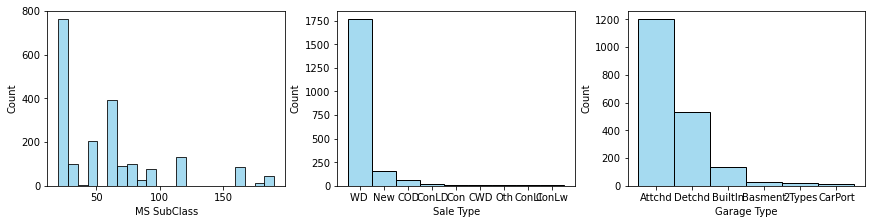

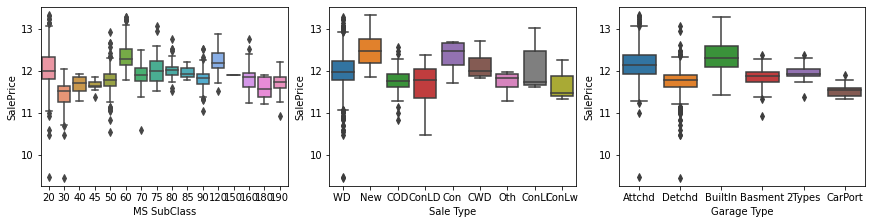

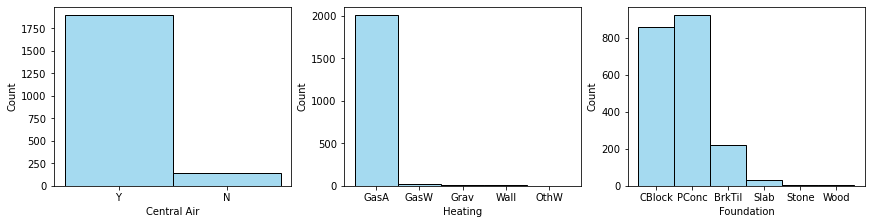

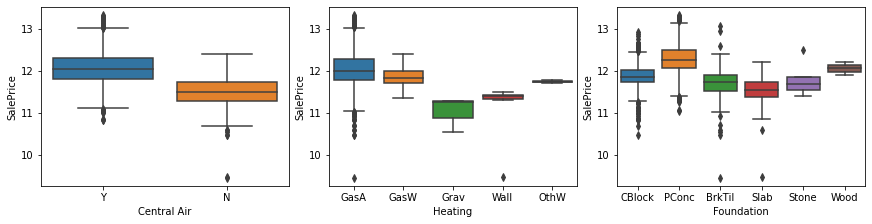

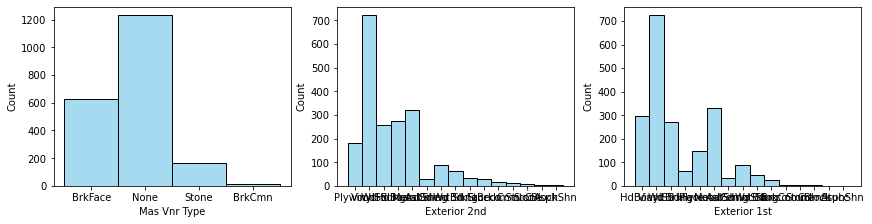

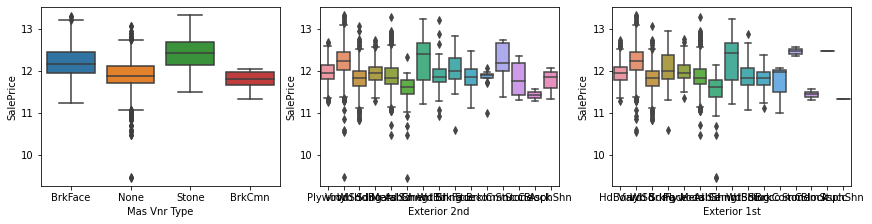

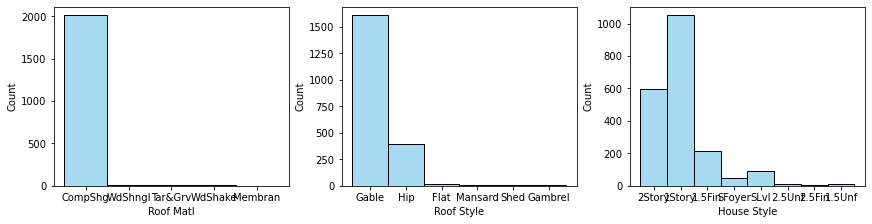

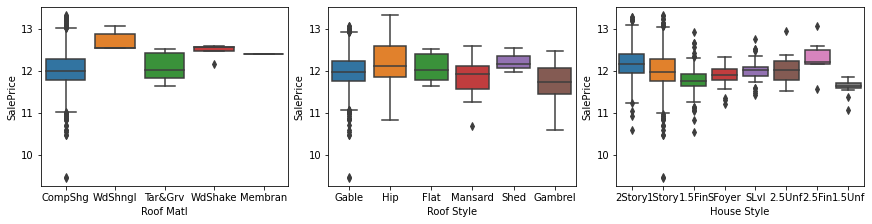

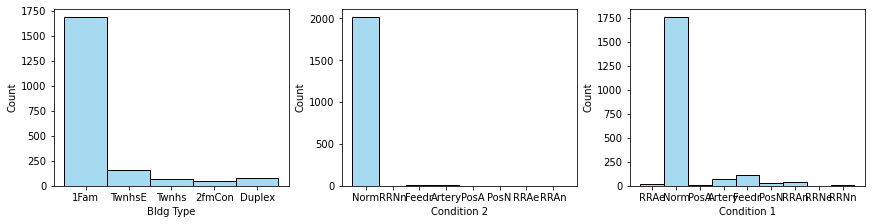

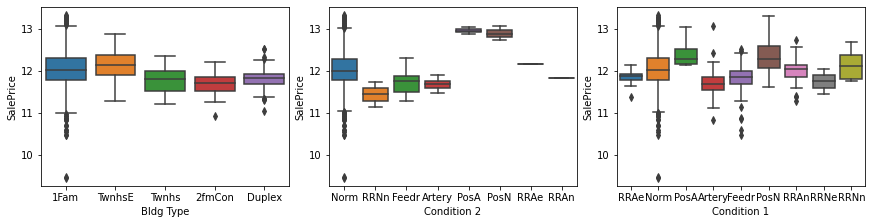

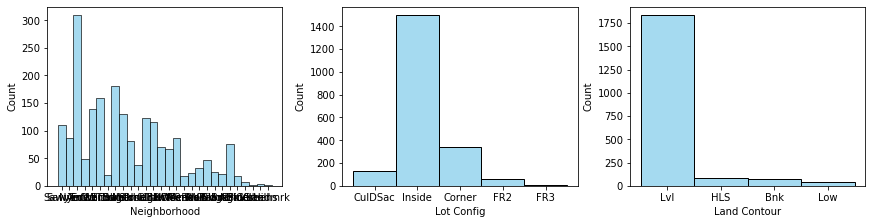

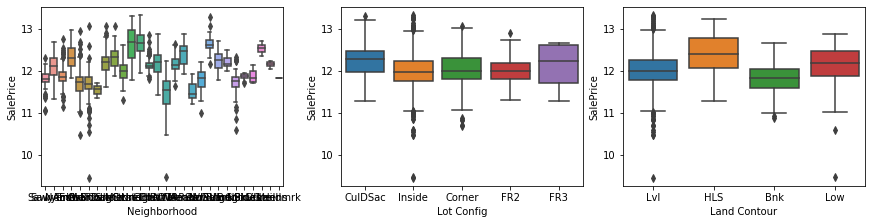

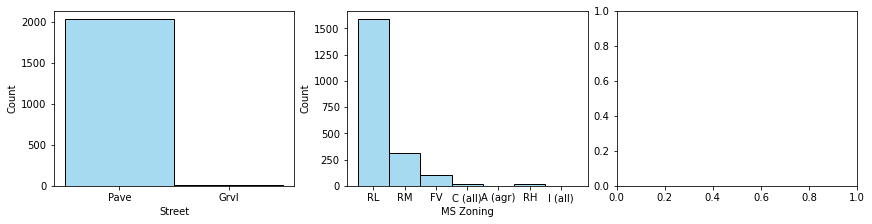

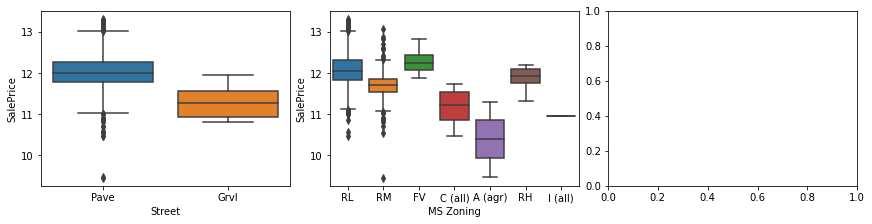

In [438]:

#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 3
while i < (len(features_categorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            sns.histplot(data=df, x=features_categorical[i+j], kde=False, color="skyblue", ax=axs[j])
      
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_categorical[i+j], y=target_variable, data=df, ax=axs2[j])
            
    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
   
    i +=columns_in_a_row


# EDA

### EDA categorical features


#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
features_to_compare=features_categorical
columns_in_a_row = 3
while i < (len(features_to_compare)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_to_compare)):
            sns.histplot(data=df, x=features_to_compare[i+j], kde=False, color="skyblue", ax=axs[j])
      
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_to_compare)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_to_compare[i+j], y=target_variable, data=df, ax=axs2[j])
            
    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
   
    i +=columns_in_a_row

### EDA ordinal features


#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
features_to_compare=features_ordinal
columns_in_a_row = 3
while i < (len(features_to_compare)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_to_compare)):
            sns.histplot(data=df, x=features_to_compare[i+j], kde=False, color="skyblue", ax=axs[j])
      
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_to_compare)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_to_compare[i+j], y=target_variable, data=df, ax=axs2[j])
            
    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
   
    i +=columns_in_a_row

### EDA numerical features


#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
features_to_compare=features_numeric
columns_in_a_row = 3
while i < (len(features_to_compare)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_to_compare)):
            sns.histplot(data=df, x=features_to_compare[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_to_compare[i:min(i+columns_in_a_row,len(features_to_compare))], y_vars=target_variable)
    i +=columns_in_a_row

# cleaning and selecting numeric features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

## check and handle outliers of features_numeric[0:5]

In [38]:
df.shape

(2051, 76)

['Lot Area', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2']


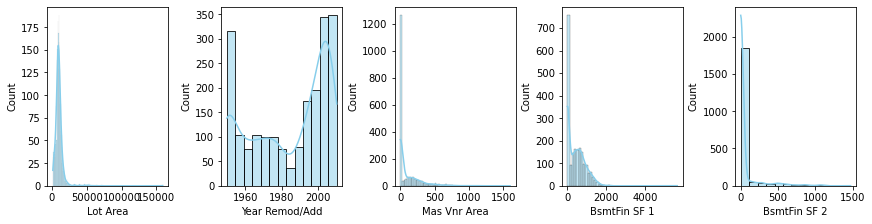

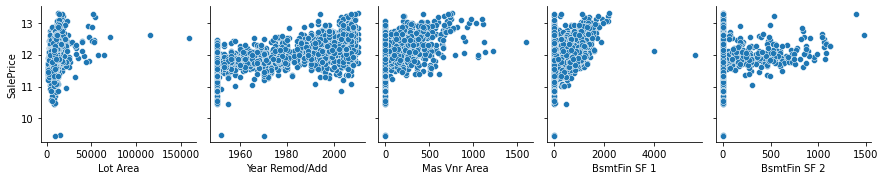

In [412]:
print(features_numeric[:5])
plot_features_numeric(df,features_numeric[:5],target_variable)

In [413]:
# features_numeric[0], features_numeric[3], and features_numeric[4] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [0,3,4]
outliers_values = [100_000, 3_000, 1_400]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of Lot Area:  2
deleted outliers of Lot Area
number of outliers of BsmtFin SF 1:  2
deleted outliers of BsmtFin SF 1
number of outliers of BsmtFin SF 2:  1
deleted outliers of BsmtFin SF 2


(2046, 76)


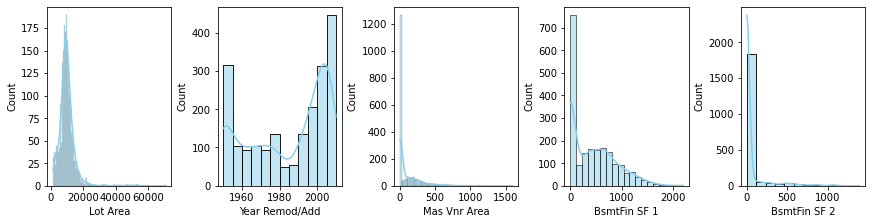

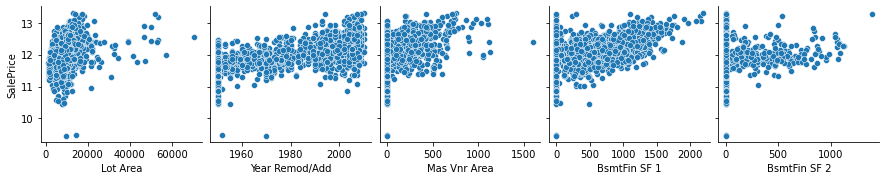

In [414]:
print(df.shape)
plot_features_numeric(df,features_numeric[:5],target_variable) 

## check and handle outliers of features_numeric[5:10]

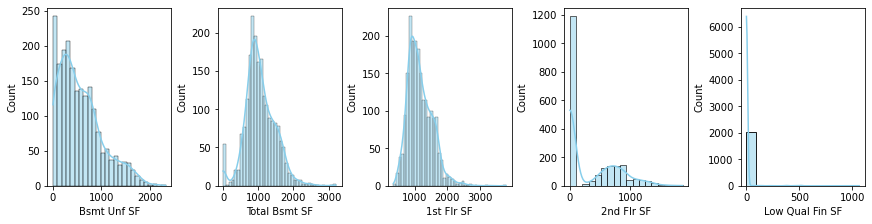

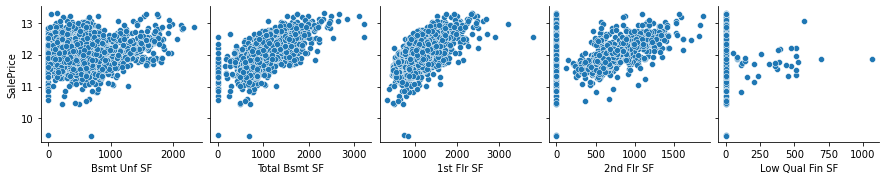

In [415]:
plot_features_numeric(df,features_numeric[5:10],target_variable)

In [416]:
# features_numeric[5], features_numeric[7], and features_numeric[8] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [7,9]
outliers_values = [3_000, 750]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of 1st Flr SF:  2
deleted outliers of 1st Flr SF
number of outliers of Low Qual Fin SF:  1
deleted outliers of Low Qual Fin SF


(2043, 76)


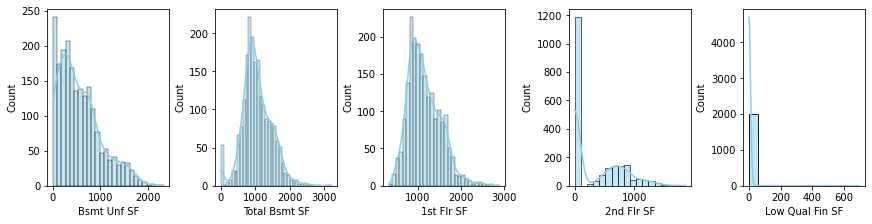

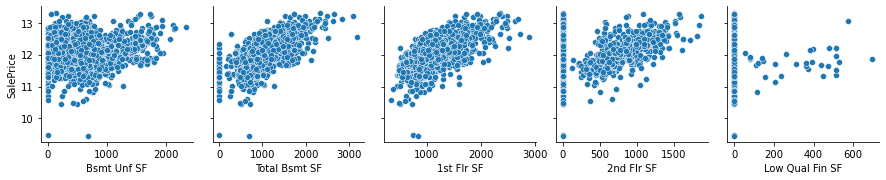

In [417]:
print(df.shape)
plot_features_numeric(df,features_numeric[5:10],target_variable) 

## check and handle outliers of features_numeric[10:15]

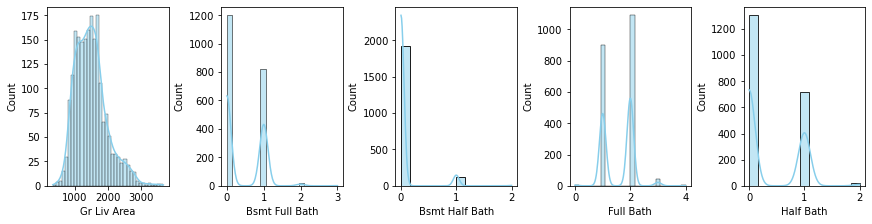

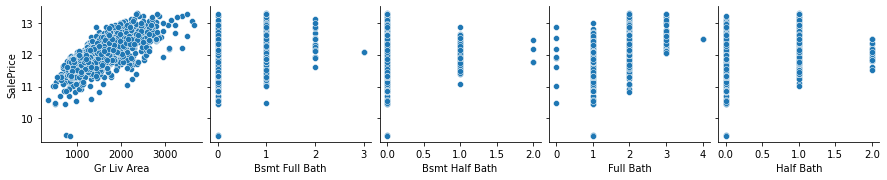

In [418]:
plot_features_numeric(df,features_numeric[10:15],target_variable)

In [419]:
print("No outliers found")


No outliers found


## check and handle outliers of features_numeric[15:20]

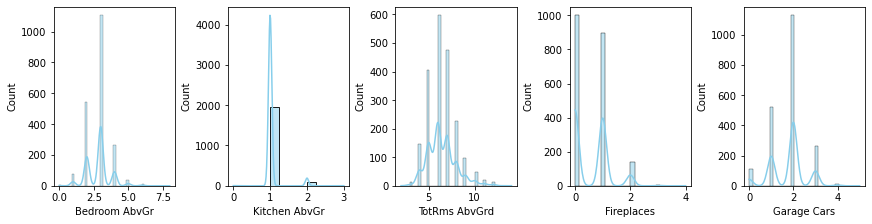

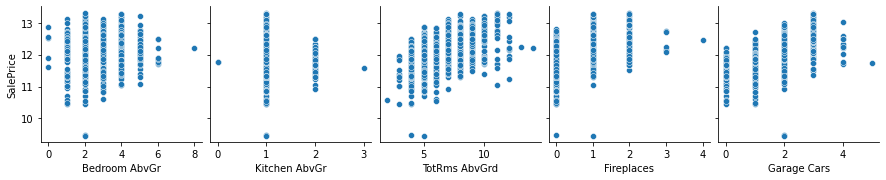

In [420]:
plot_features_numeric(df,features_numeric[15:20],target_variable)

In [421]:
print("No outliers found")

No outliers found


## check and handle outliers of features_numeric[20:25]

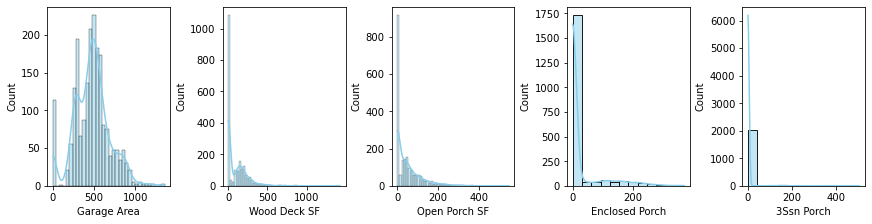

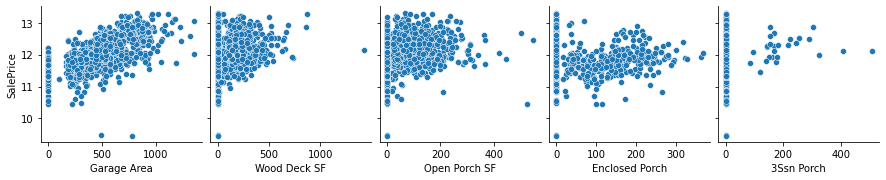

In [422]:
plot_features_numeric(df,features_numeric[20:25],target_variable)

In [423]:
# features_numeric[21], features_numeric[23], and features_numeric[24] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [21,22,24]
outliers_values = [1_000, 420, 400]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of Wood Deck SF:  1
deleted outliers of Wood Deck SF
number of outliers of Open Porch SF:  4
deleted outliers of Open Porch SF
number of outliers of 3Ssn Porch:  2
deleted outliers of 3Ssn Porch


(2036, 76)


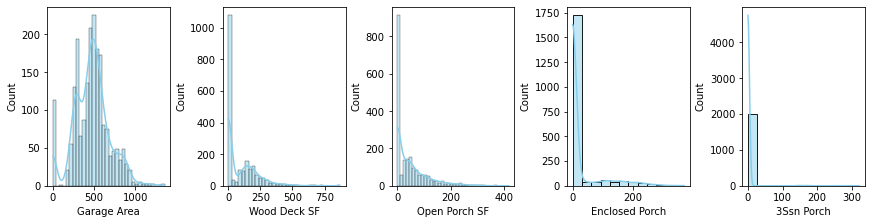

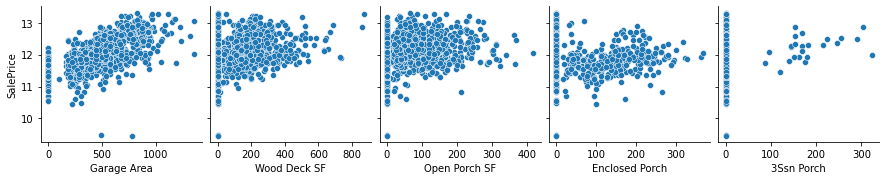

In [424]:
print(df.shape)
plot_features_numeric(df,features_numeric[20:25],target_variable) 

## check and handle outliers of features_numeric[25:30]

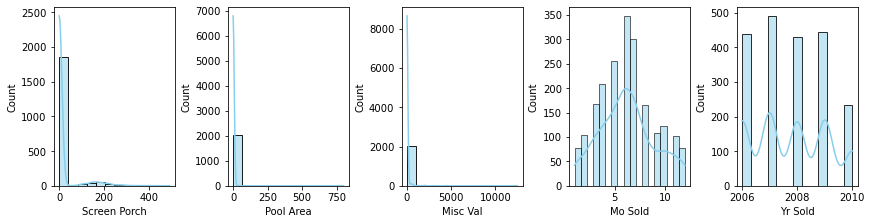

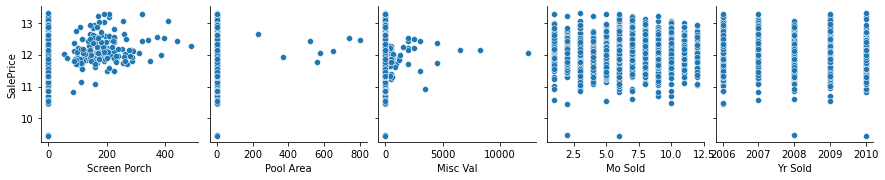

In [425]:
plot_features_numeric(df,features_numeric[25:30],target_variable)

In [426]:
print("No outliers found")


No outliers found


## check and handle outliers of features_numeric[30:35]

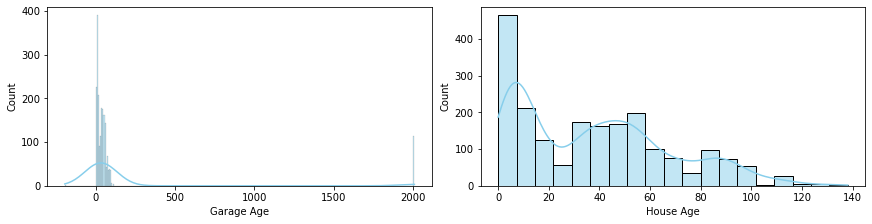

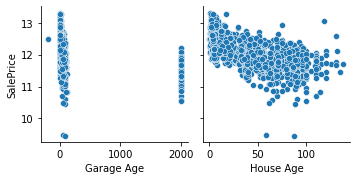

In [427]:
plot_features_numeric(df,features_numeric[30:35],target_variable)

In [428]:
print("No outliers found")

No outliers found


In [429]:
df.shape

(2036, 76)

In [343]:
'''
ordinal_cols_mapping = {
    #"Lot Shape": {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    #"Utilities": {'AllPub':3, 'NoSewr':2, 'NoSeWa':1,  'ELO':0},
    #"Land Slope": {'Gtl':2, 'Mod':1 ,'Sev':0},
    #"Exter Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    #"Exter Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    #"Bsmt Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    #"Bsmt Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    #"Bsmt Exposure": {'Gd':4, 'Av':3, 'Mn':2 ,'No':1, 'NA':0},
    #"BsmtFin Type 1": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    #"BsmtFin Type 2": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    #"Heating QC": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    #"Electrical": {'SBrkr':4, 'FuseA':3, 'FuseF':2 ,'FuseP':1, 'Mix':0},
    "Kitchen Qual": {'Po':0},
    #"Functional": {'Typ':4, 'Min1':3, 'Min2':2 ,'Mod':1, 'Maj1':0, 'Maj2':-1, 'Sev':-2,'Sal':-3},
    #"Garage Finish": {'Fin':4, 'RFn':3, 'Unf':2 ,'NA':1},
    #"Garage Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    #"Garage Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    #"Paved Drive": {'Y':2, 'P':1 ,'N':0}
}

 
  
#df = df.replace(ordinal_cols_mapping)
X_kaggle = X_kaggle.replace(ordinal_cols_mapping)
X_kaggle.info()
'''

'\nordinal_cols_mapping = {\n    #"Lot Shape": {\'Reg\':3, \'IR1\':2, \'IR2\':1, \'IR3\':0},\n    #"Utilities": {\'AllPub\':3, \'NoSewr\':2, \'NoSeWa\':1,  \'ELO\':0},\n    #"Land Slope": {\'Gtl\':2, \'Mod\':1 ,\'Sev\':0},\n    #"Exter Qual": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0},\n    #"Exter Cond": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0},\n    #"Bsmt Qual": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0, \'NA\':-1},\n    #"Bsmt Cond": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0, \'NA\':-1},\n    #"Bsmt Exposure": {\'Gd\':4, \'Av\':3, \'Mn\':2 ,\'No\':1, \'NA\':0},\n    #"BsmtFin Type 1": {\'GLQ\':4, \'ALQ\':3, \'BLQ\':2 ,\'Rec\':1, \'LwQ\':0, \'Unf\':-1, \'NA\':-2},\n    #"BsmtFin Type 2": {\'GLQ\':4, \'ALQ\':3, \'BLQ\':2 ,\'Rec\':1, \'LwQ\':0, \'Unf\':-1, \'NA\':-2},\n    #"Heating QC": {\'Ex\':4, \'Gd\':3, \'TA\':2 ,\'Fa\':1, \'Po\':0},\n    #"Electrical": {\'SBrkr\':4, \'FuseA\':3, \'FuseF\':2 ,\'FuseP\':1, \'Mix\':0},\n    "Kitchen Qual": {\'Po\':